# Titanic New Version

### Import Cell

In [1]:
!conda info --envs

In [2]:
%config IPCompleter.greedy=True

In [3]:
# Cell magic for visualization
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn as skl
import pickle


# Models
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Optimization
import optuna

# Interpretation
import shap
shap.initjs()

In [4]:
import warnings
warnings.filterwarnings("ignore")

### Import training Dataset

In [5]:
train  = pd.read_csv('Datasets/train.csv')
test = pd.read_csv('Datasets/test.csv')

In [6]:
# Initial checks
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
train.head()

Train shape: (891, 12)
Test shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
X_Pred_Passenger = test['PassengerId']

## Exploratory Data Analysis

In [8]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
train["Survived"].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

In [10]:
# Seperate the features
numerical_features = train.select_dtypes(include=['number'])
numerical_features = numerical_features.drop(columns=['Survived','PassengerId','Pclass'])
categorical_features = train.select_dtypes(exclude=['number'])
categorical_features_pred = test.select_dtypes(exclude=['number'])
# categorical_features_pred = categorical_features_pred.to_frame()
categorical_features["Pclass"] = train["Pclass"]
categorical_features_pred["Pclass"] = test["Pclass"]
categorical_features = categorical_features.drop(columns=['Name','Ticket'])
categorical_features_pred = categorical_features_pred.drop(columns=['Name','Ticket'])
target_column = "Survived"

### Numerical Data Heatmap Feature Correlations

In [11]:
def heatmap(numerical_features) :
    plt.figure(figsize=(10, 8))
    correlation_matrix = numerical_features.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Heatmap of Numerical Features')
    plt.show()

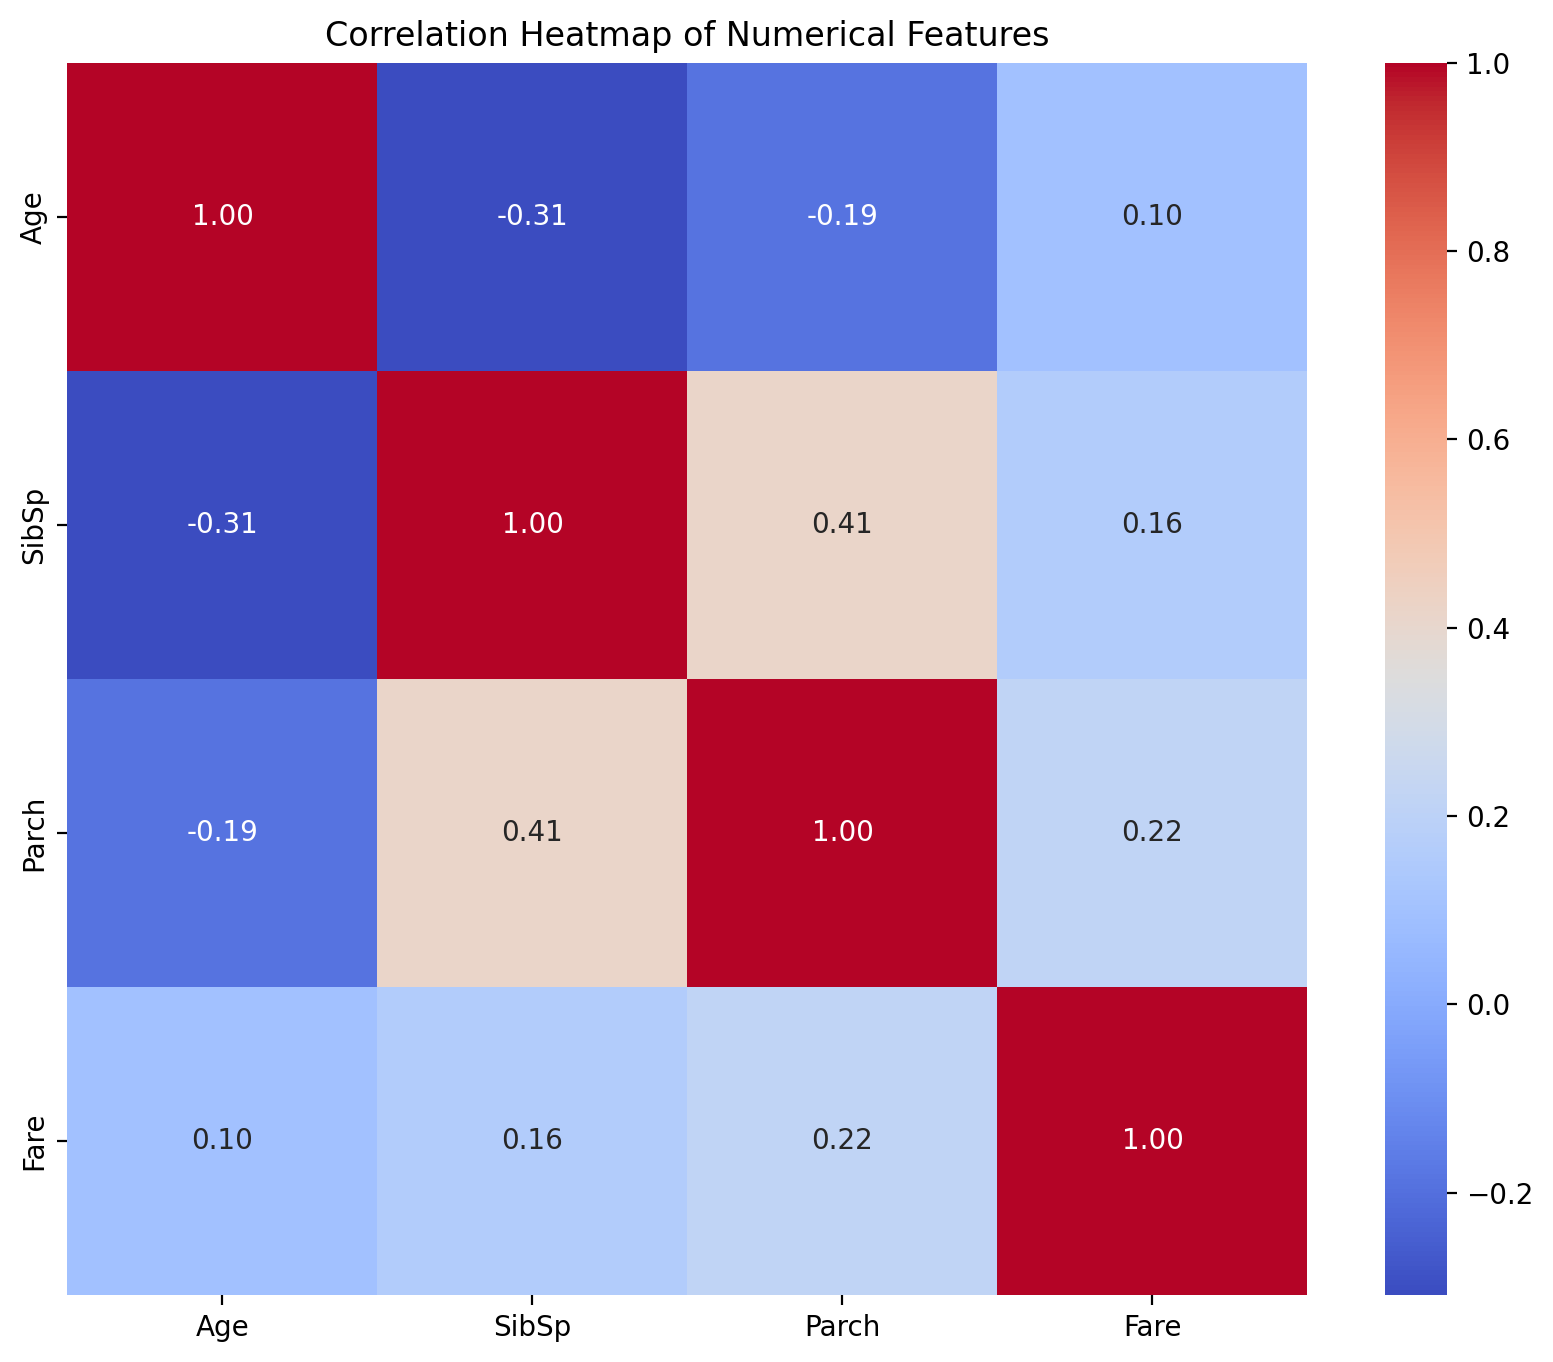

In [12]:
heatmap(numerical_features)

### Bar Plots of Numerical Features vs. Target Variable

In [13]:
def bar_plots_numerical_features(train, numerical_features, target_column) :
    for feature in numerical_features:
        plt.figure(figsize=(8, 6))
        sns.barplot(data=train, x=target_column, y=feature)
        plt.title(f'Mean {feature} by {target_column}')
        plt.xlabel(target_column)
        plt.ylabel(feature)
        plt.xticks([0, 1], ['Not Survived', 'Survived']) # Assuming 0 and 1 are your target labels
        plt.show()

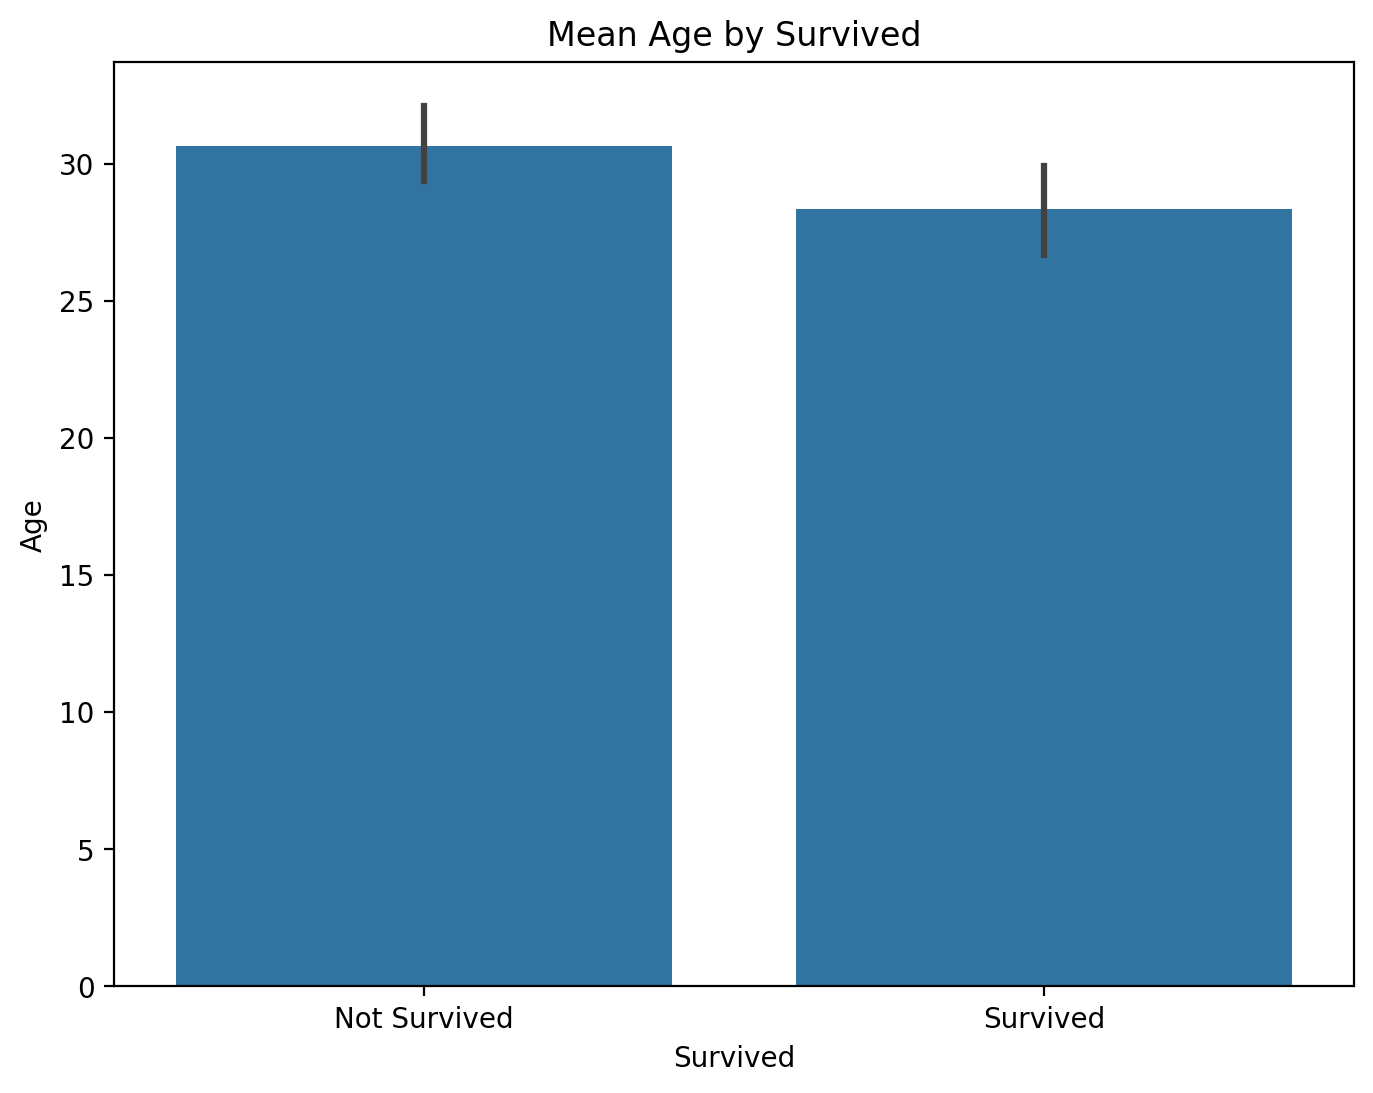

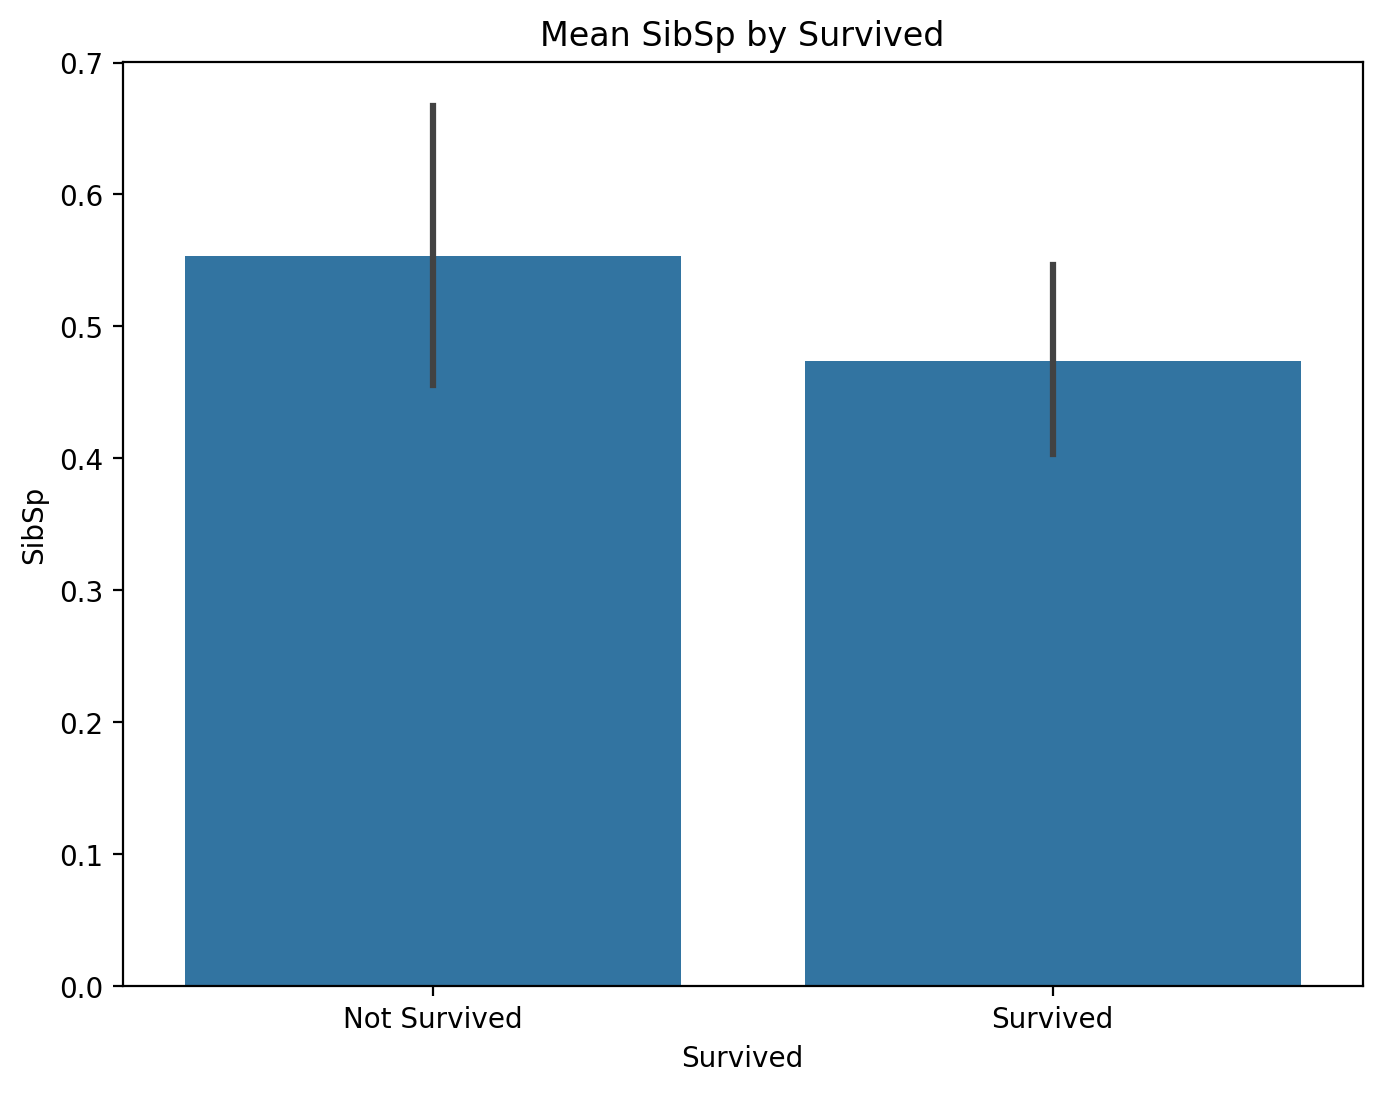

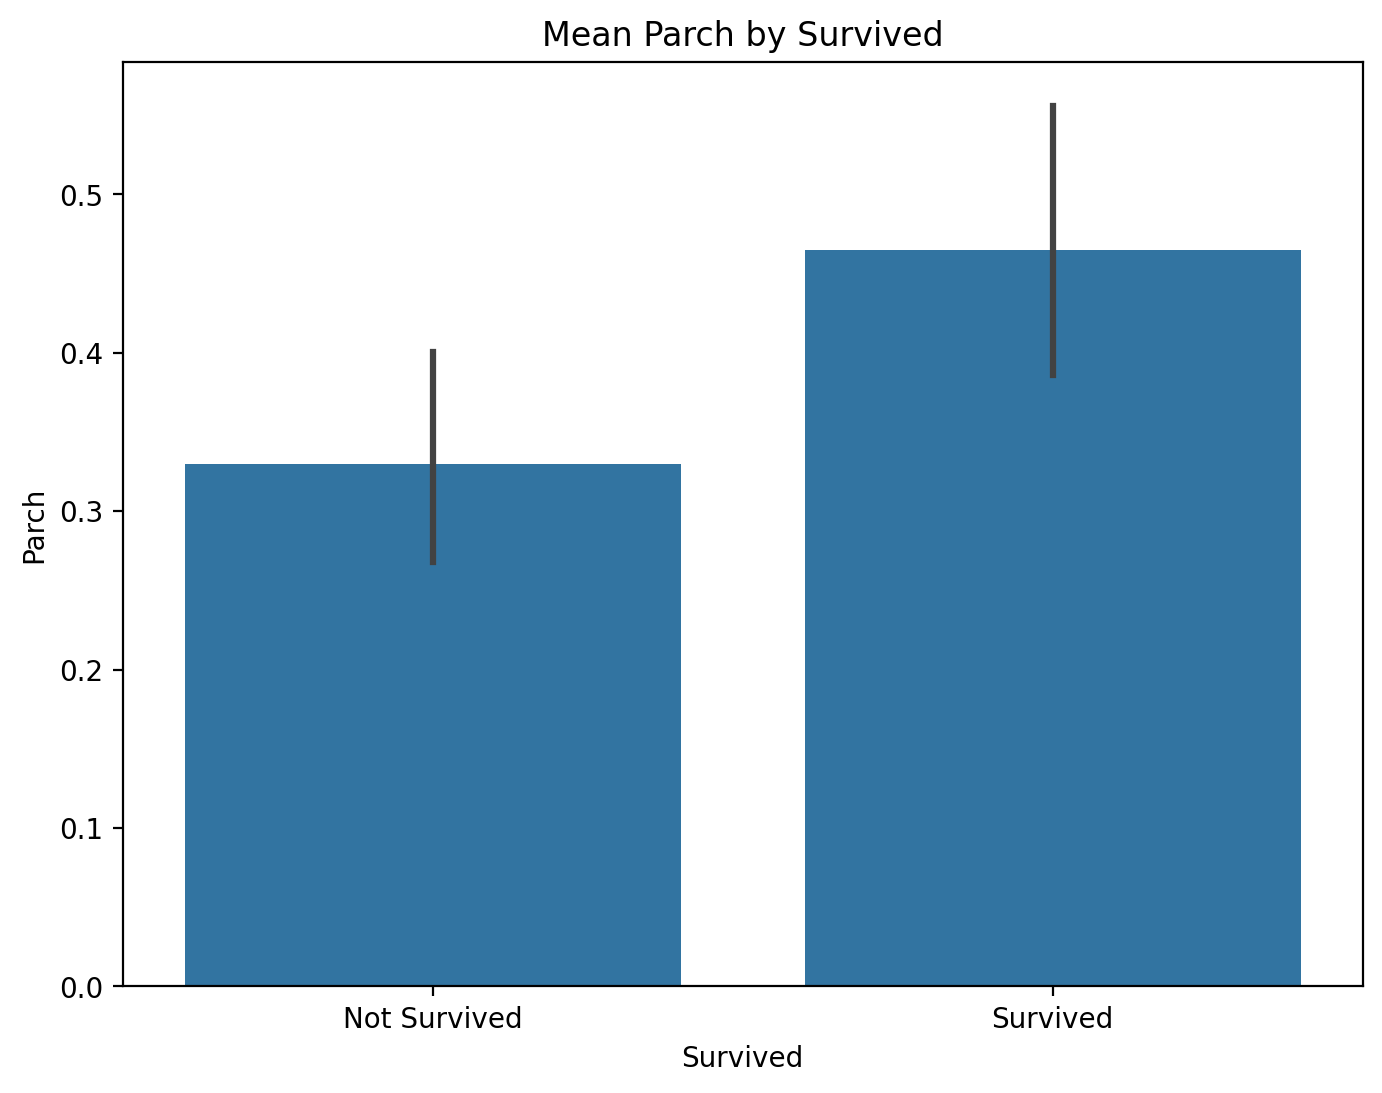

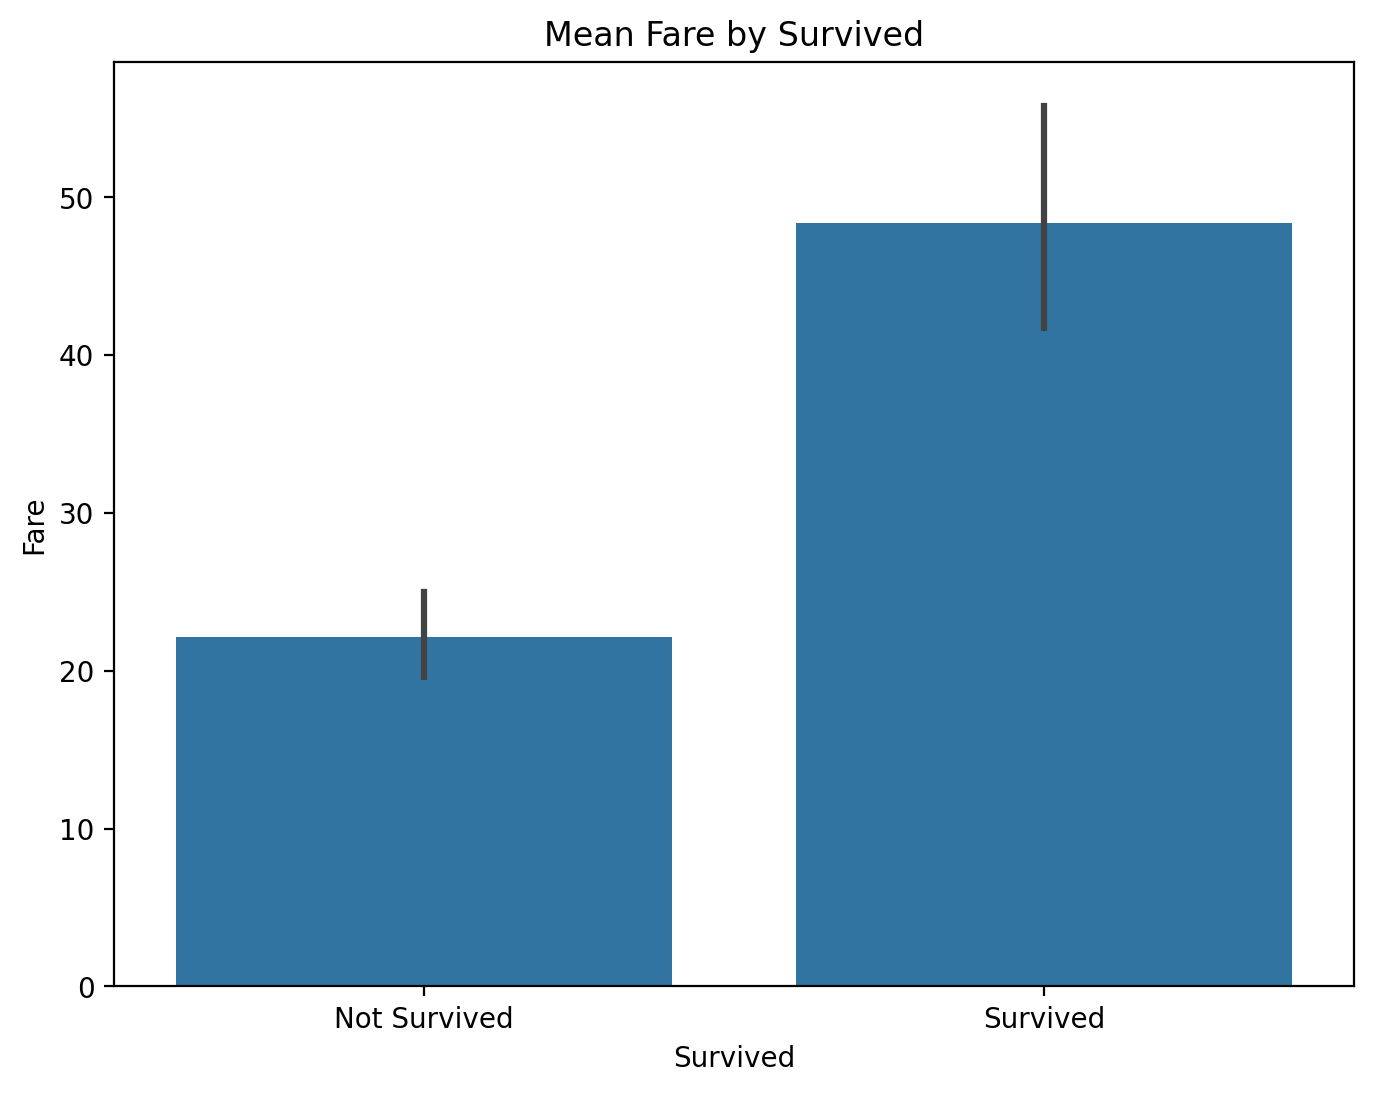

In [14]:
bar_plots_numerical_features(train, numerical_features, target_column)

### Bar Plots of Median Numerical Features vs. Target Variable

In [15]:
def bar_plots_numerical_features_median(train, numerical_features, target_column):
    for feature in numerical_features:
        plt.figure(figsize=(8, 6))
        sns.barplot(data=train, x=target_column, y=feature, estimator=np.median)
        plt.title(f'Median {feature} by {target_column}')
        plt.xlabel(target_column)
        plt.ylabel(feature)
        plt.xticks([0, 1], ['Negative Class', 'Positive Class'])
        plt.show()

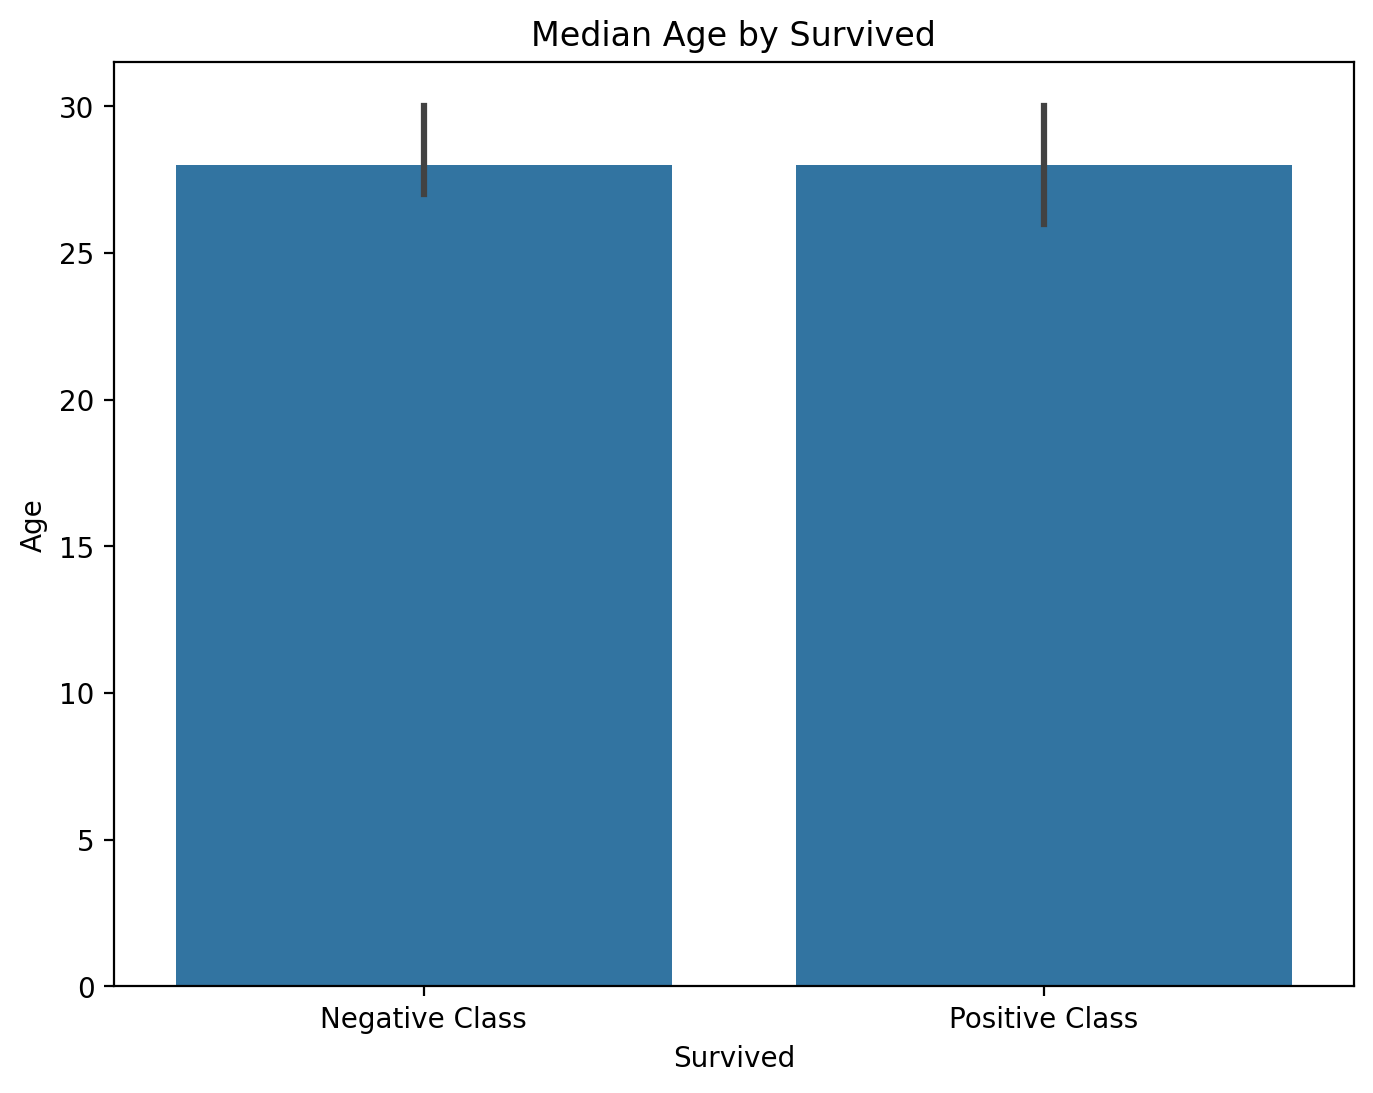

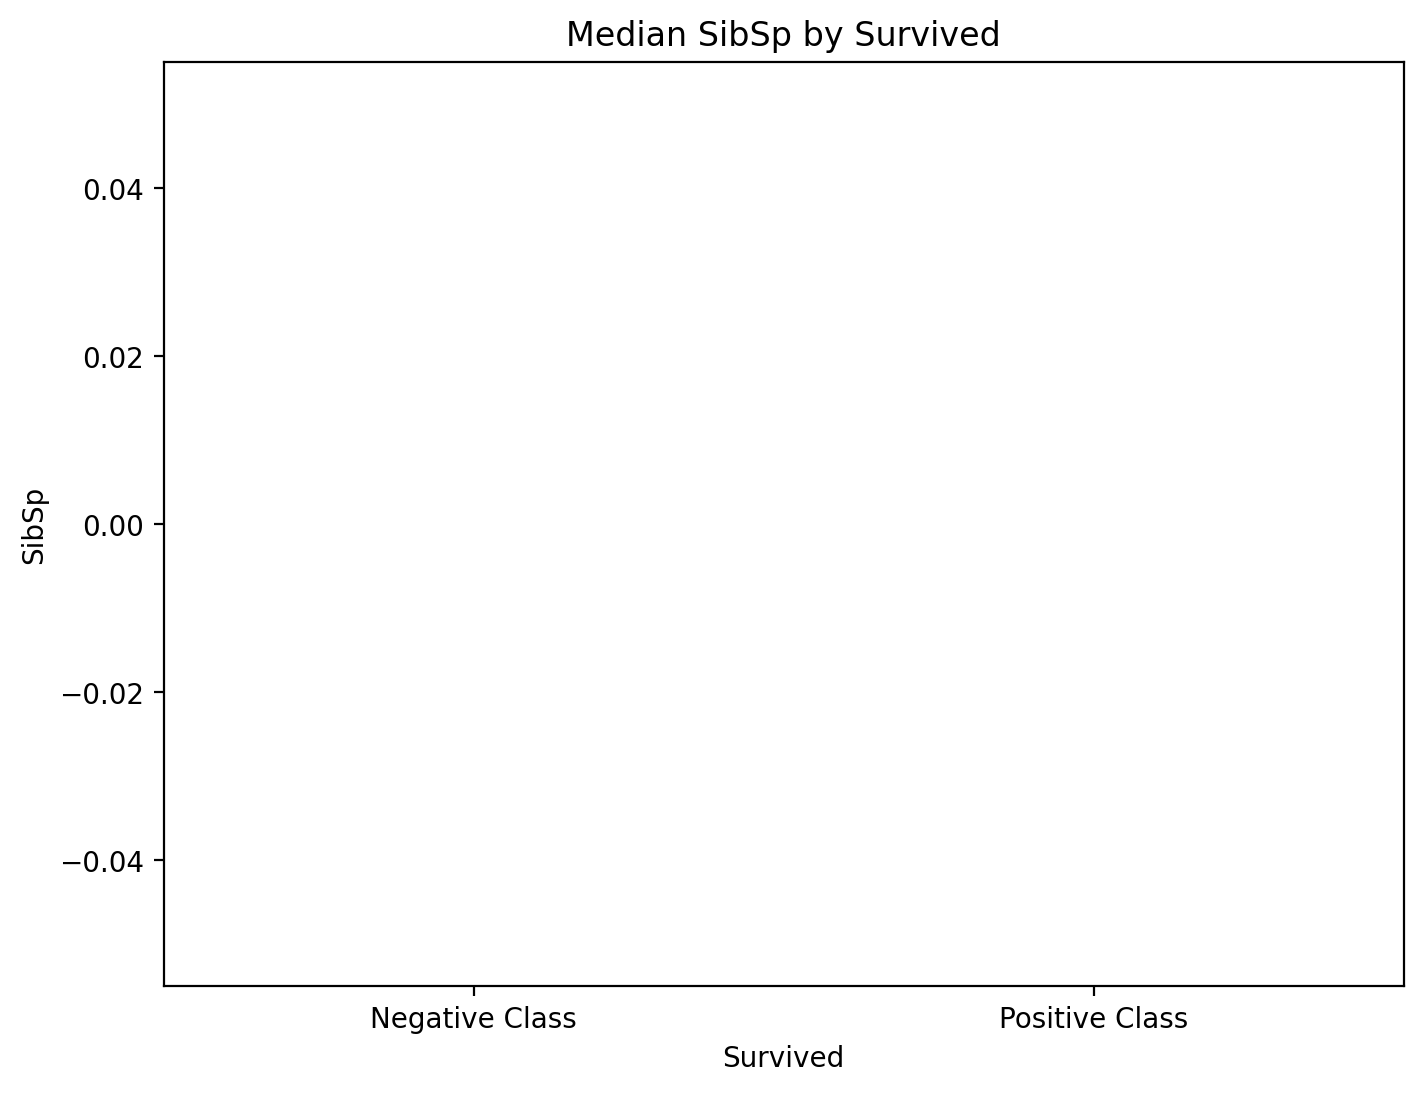

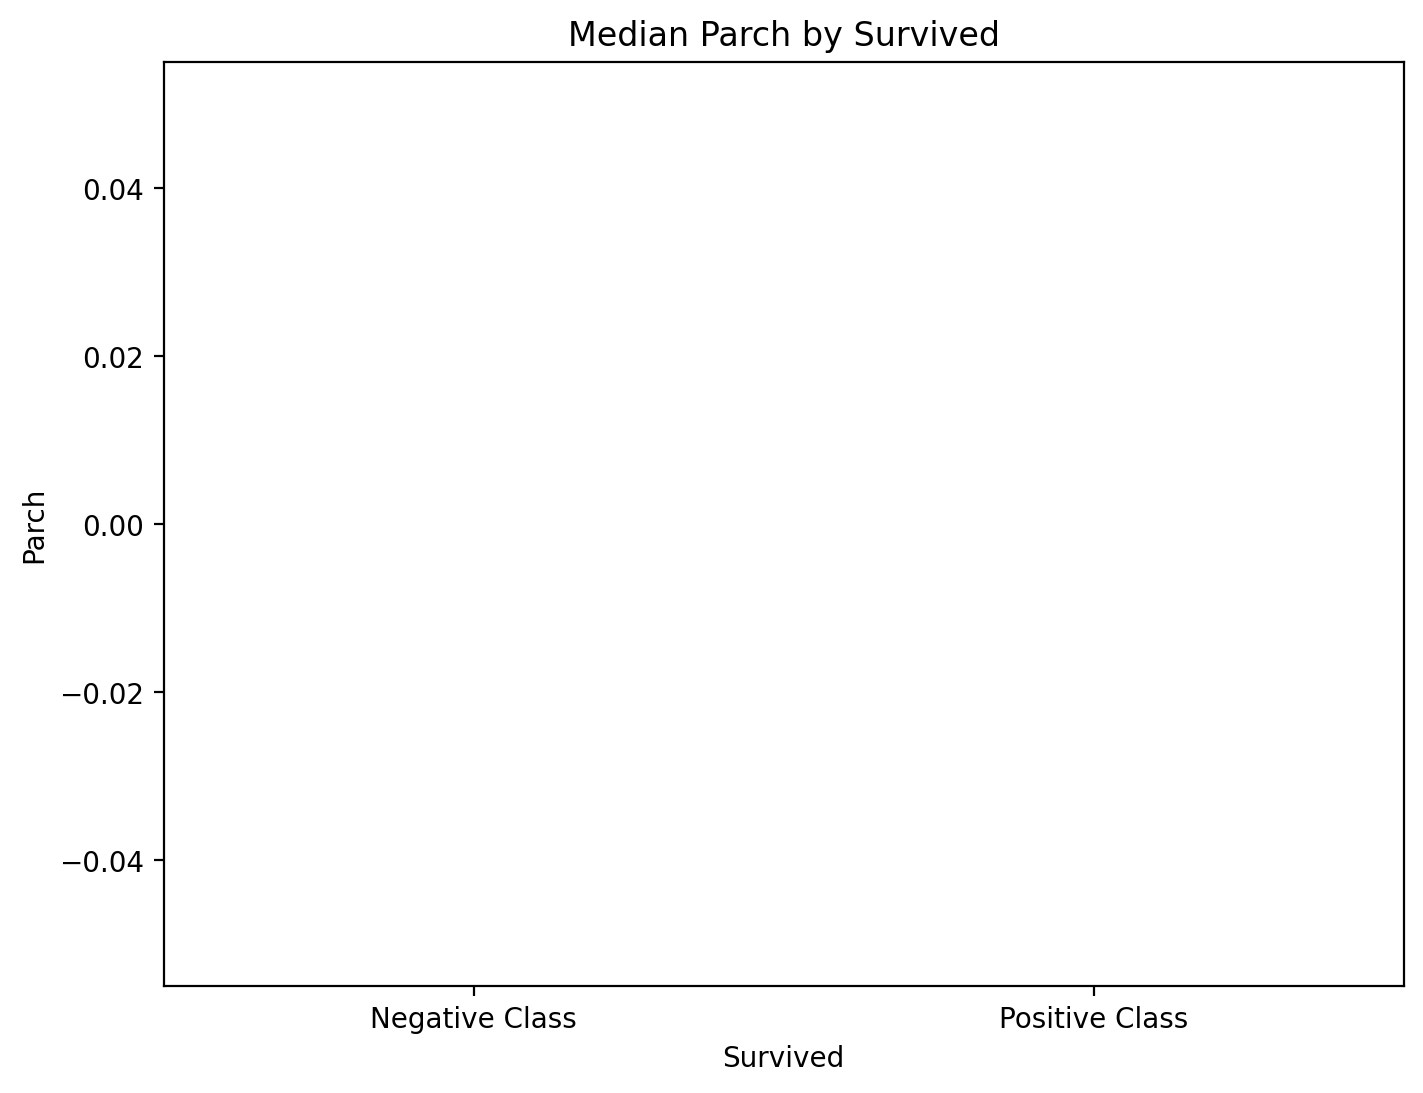

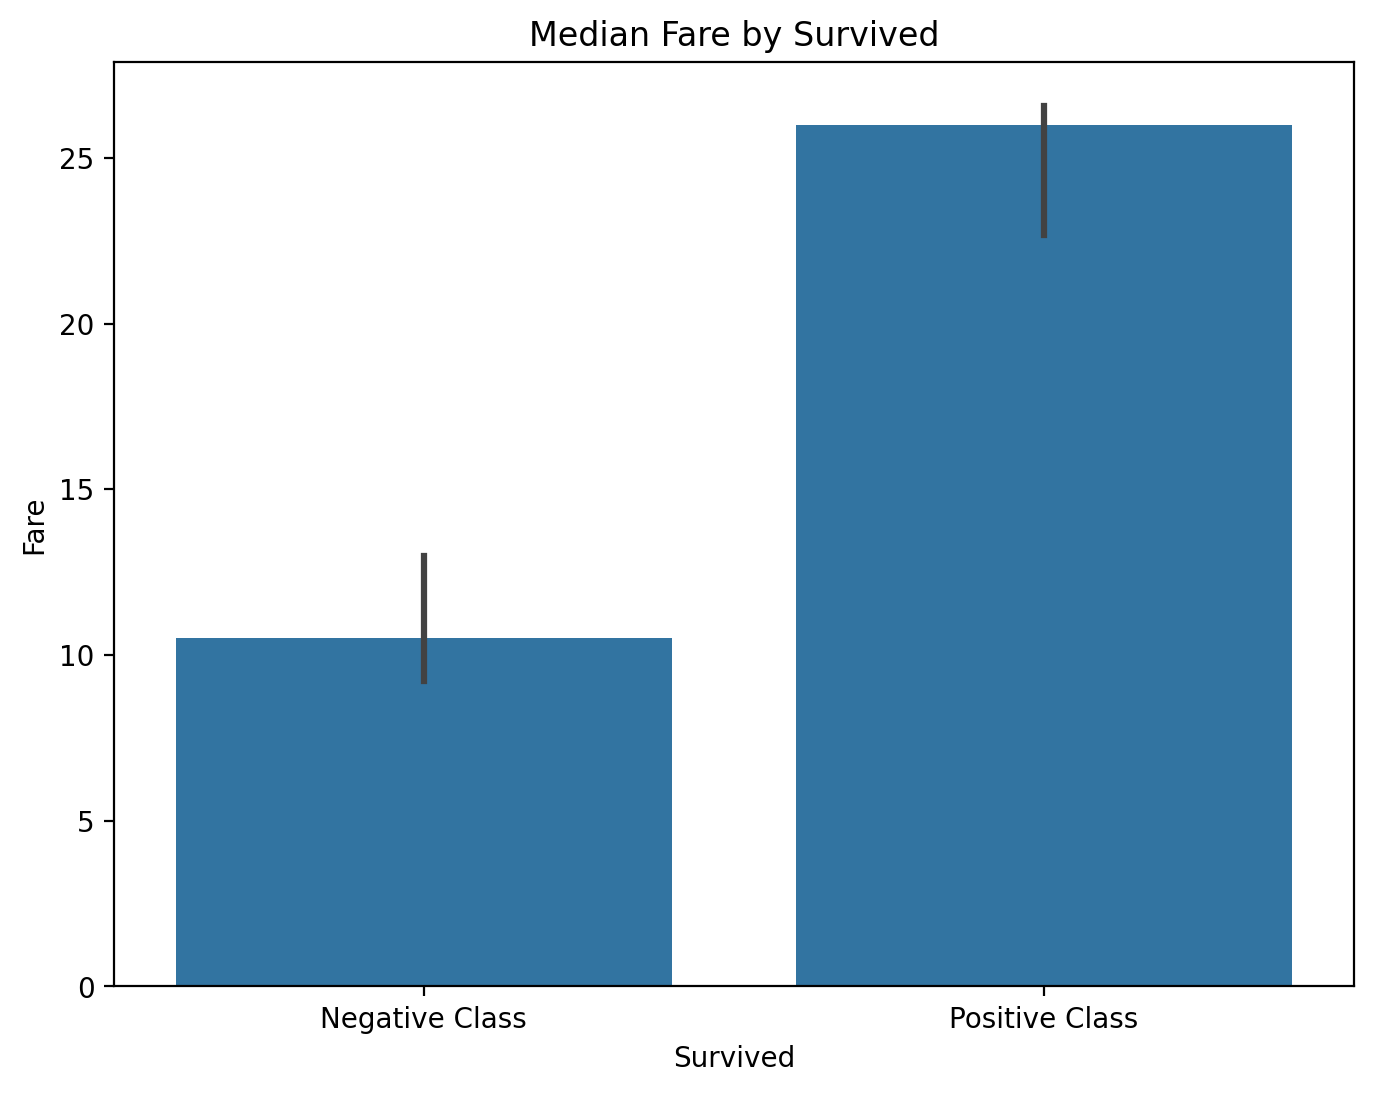

In [16]:
bar_plots_numerical_features_median(train, numerical_features, target_column)

### Distribution of Numeric Features with Histograms

In [17]:
def histograms(train, numerical_features, target_column) :
    print("\n--- Histograms of Numeric Features ---")
    for feature in numerical_features:
        plt.figure(figsize=(8, 6))
        sns.histplot(data=train, x=feature, hue=target_column, kde=False, multiple="stack")
        plt.title(f'Histogram of {feature} by {target_column}')
        plt.xlabel(feature)
        plt.ylabel('Frequency')
        plt.legend(title=target_column, labels=['No', 'Yes']) # Assuming 0 is 'No', 1 is 'Yes'
        plt.show()


--- Histograms of Numeric Features ---


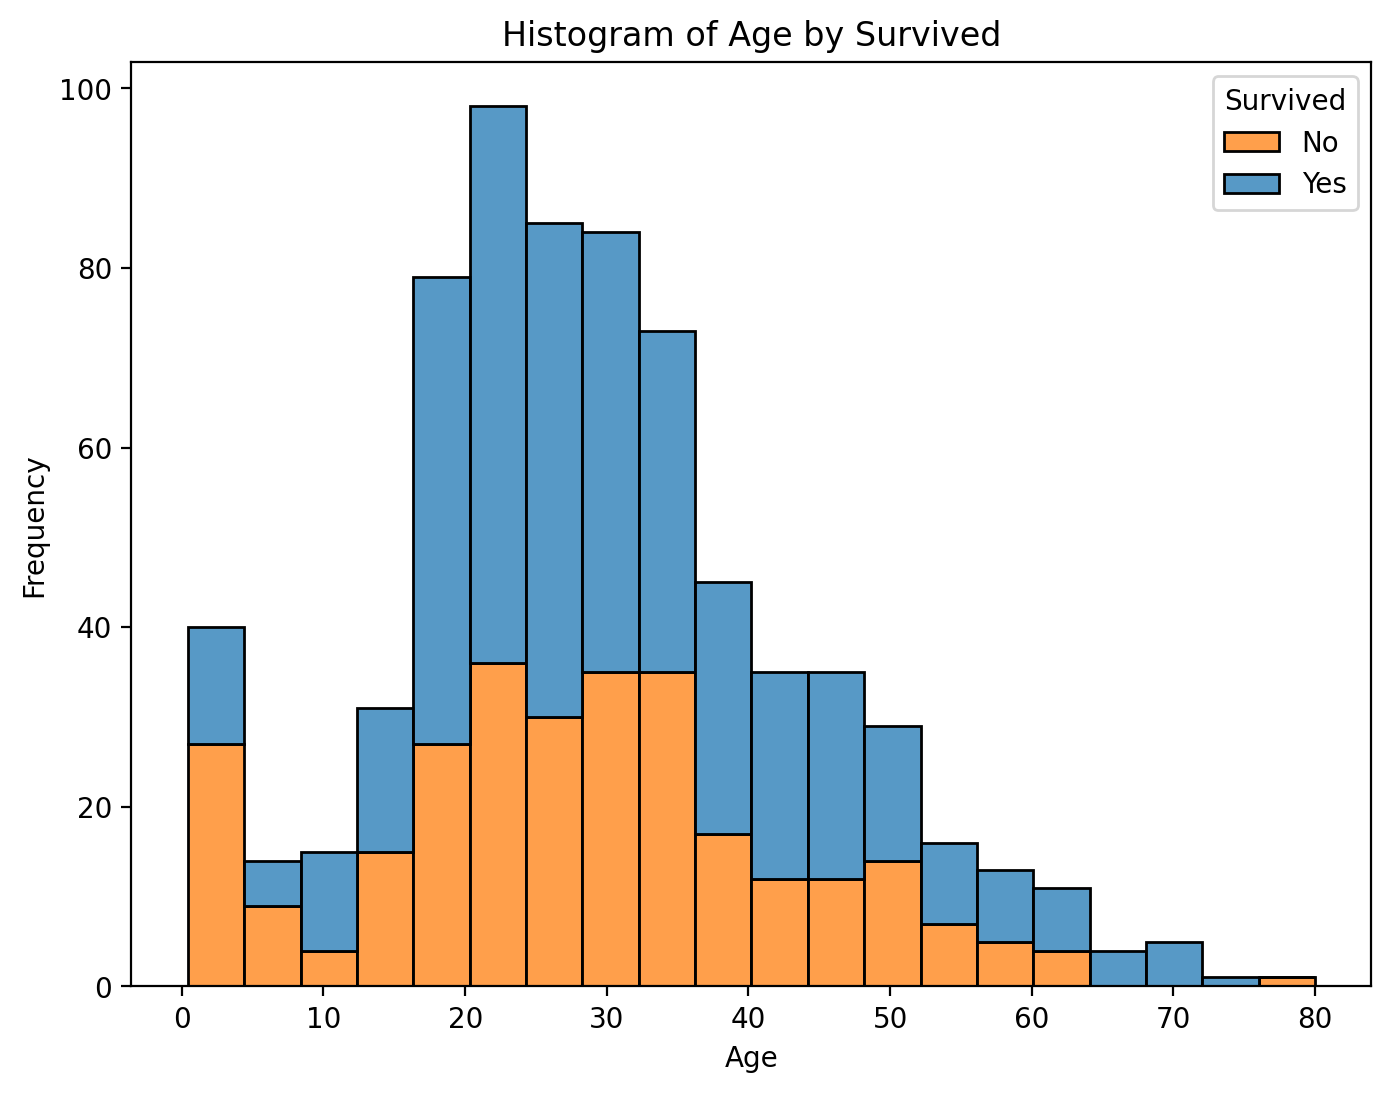

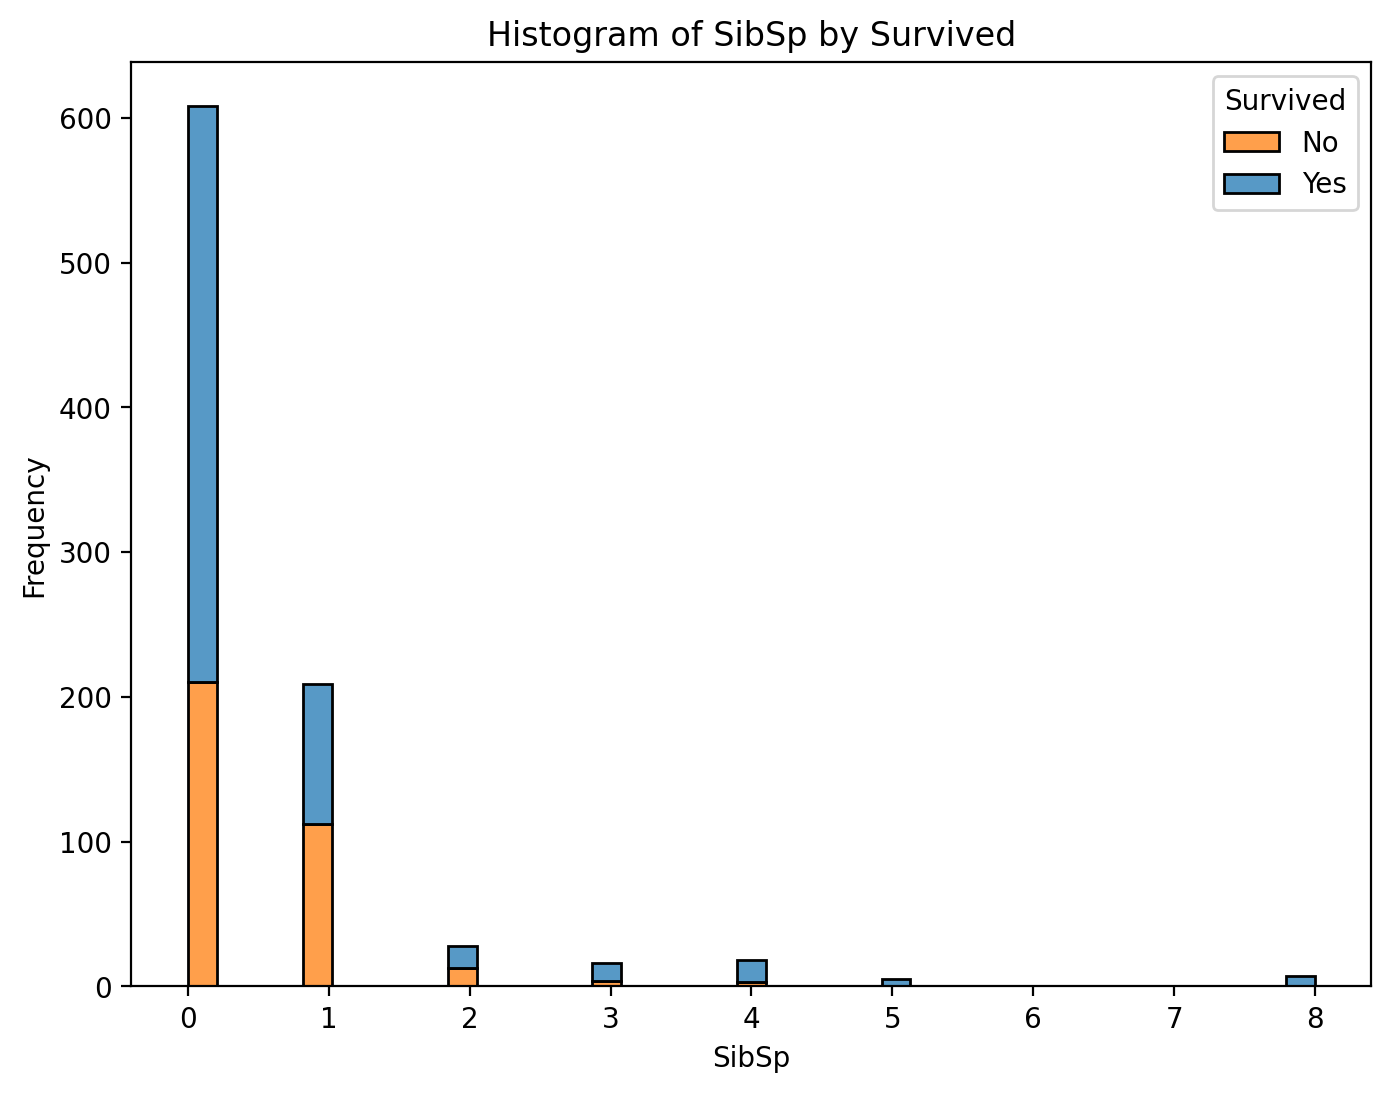

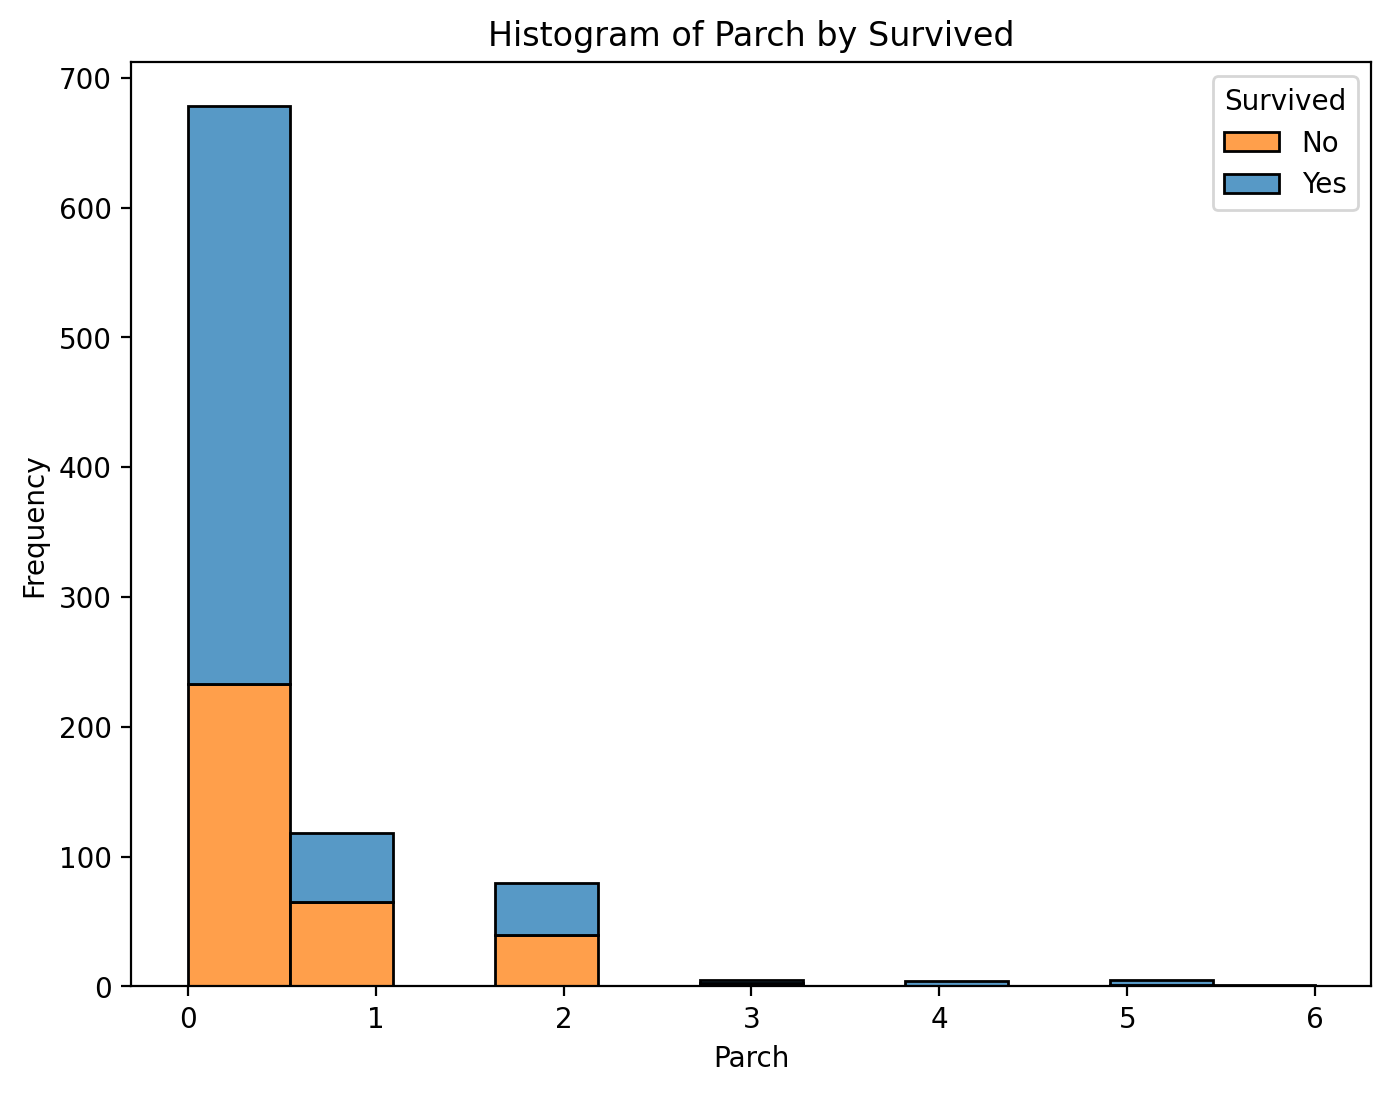

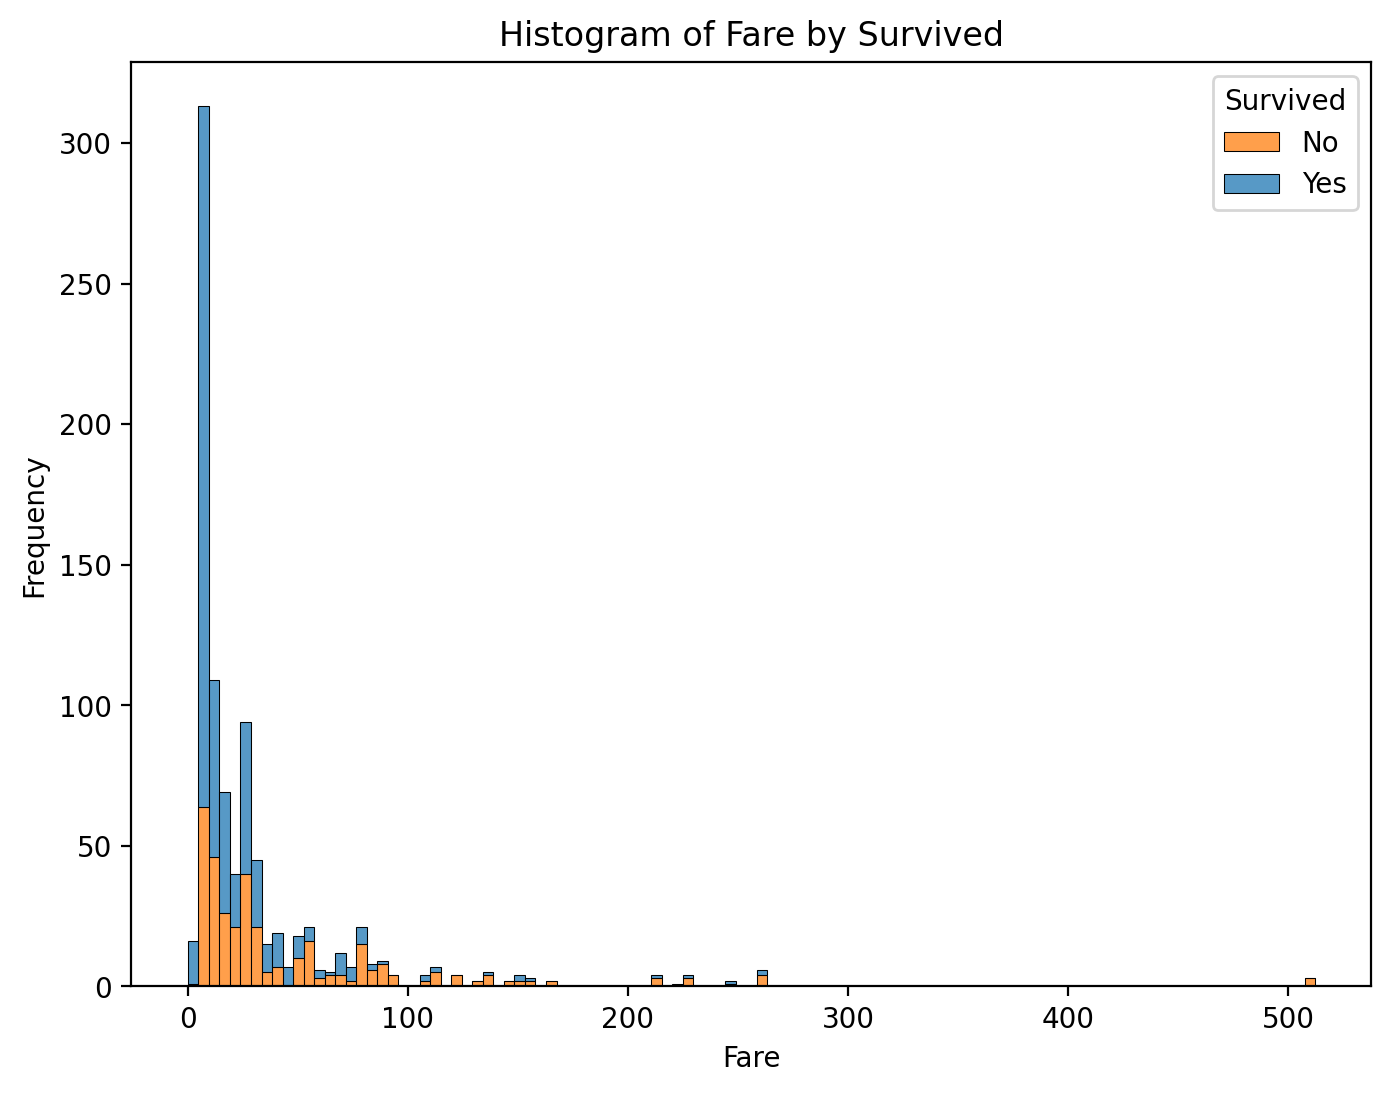

In [18]:
histograms(train, numerical_features, target_column)

### Distribution of Numeric Features with KDE Plots

In [19]:
def kde_plots(train, numerical_features, target_column) :
    print("\n--- KDE Plots of Numeric Features ---")
    for feature in numerical_features:
        plt.figure(figsize=(7, 5))
        sns.kdeplot(data=train, x=feature, hue=target_column, fill=True, alpha=.5, multiple="stack")
        plt.title(f'KDE Plot of {feature} by {target_column}')
        plt.xlabel(feature)
        plt.ylabel('Density')
        plt.legend(title=target_column, labels=['No', 'Yes']) # Assuming 0 is 'No', 1 is 'Yes'
        plt.show()


--- KDE Plots of Numeric Features ---


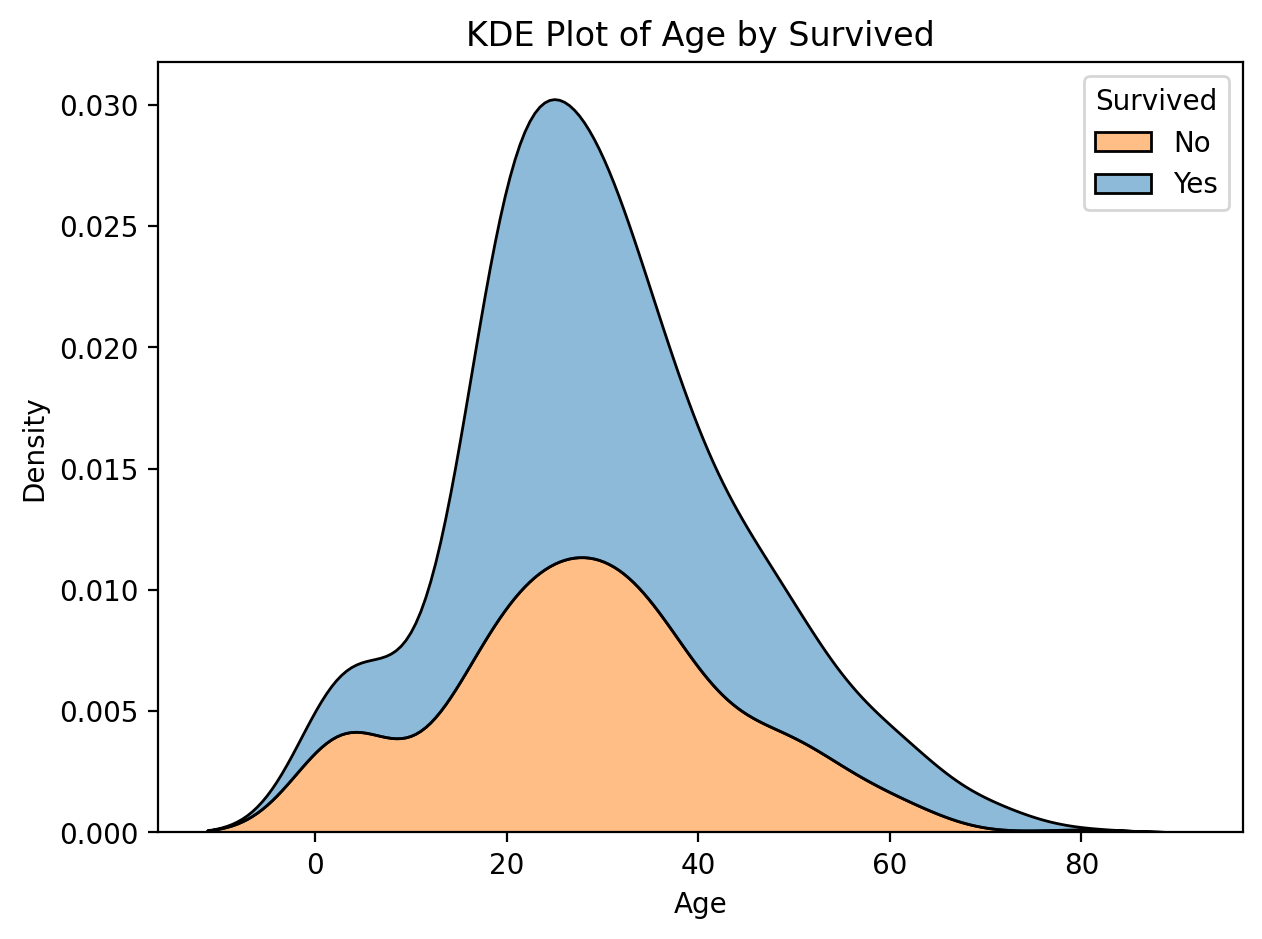

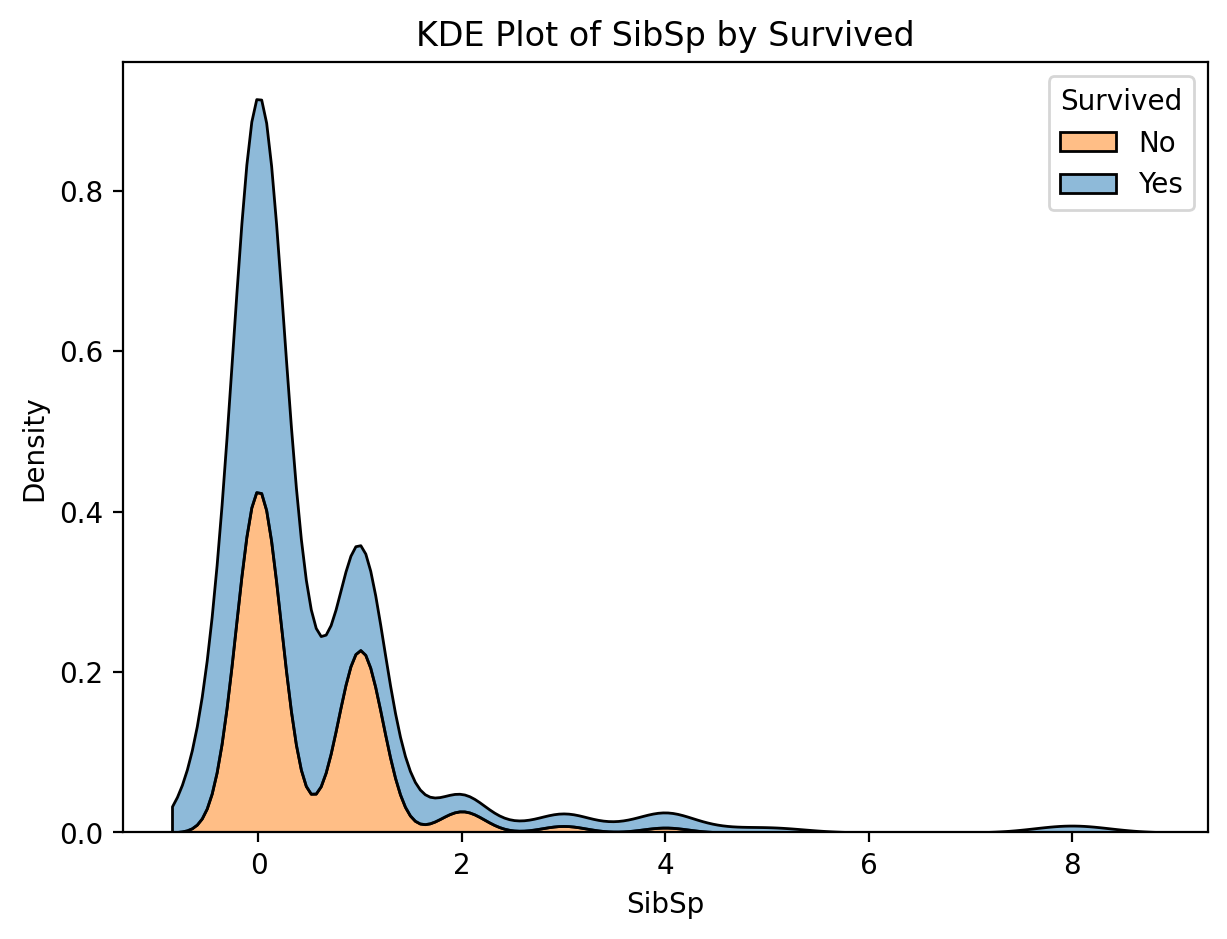

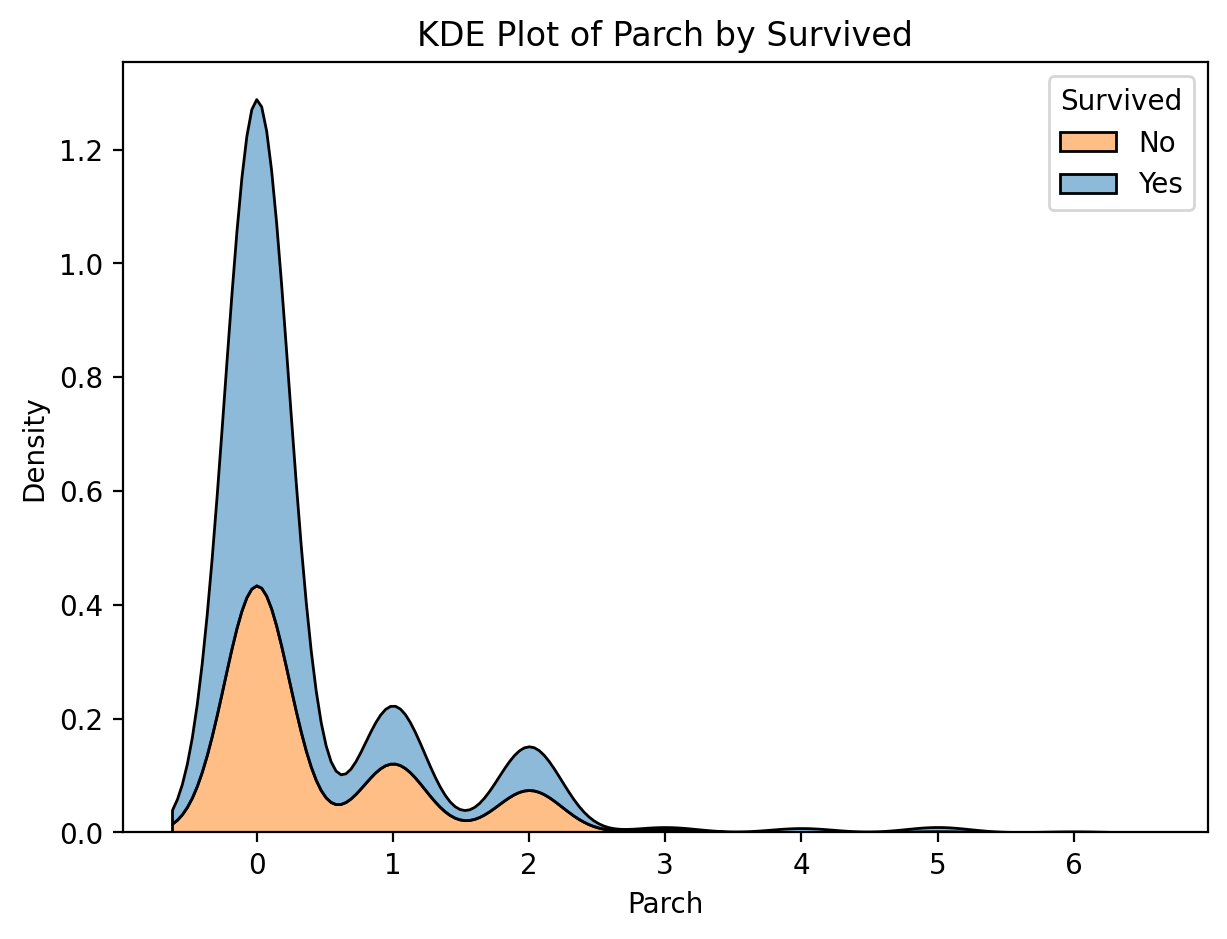

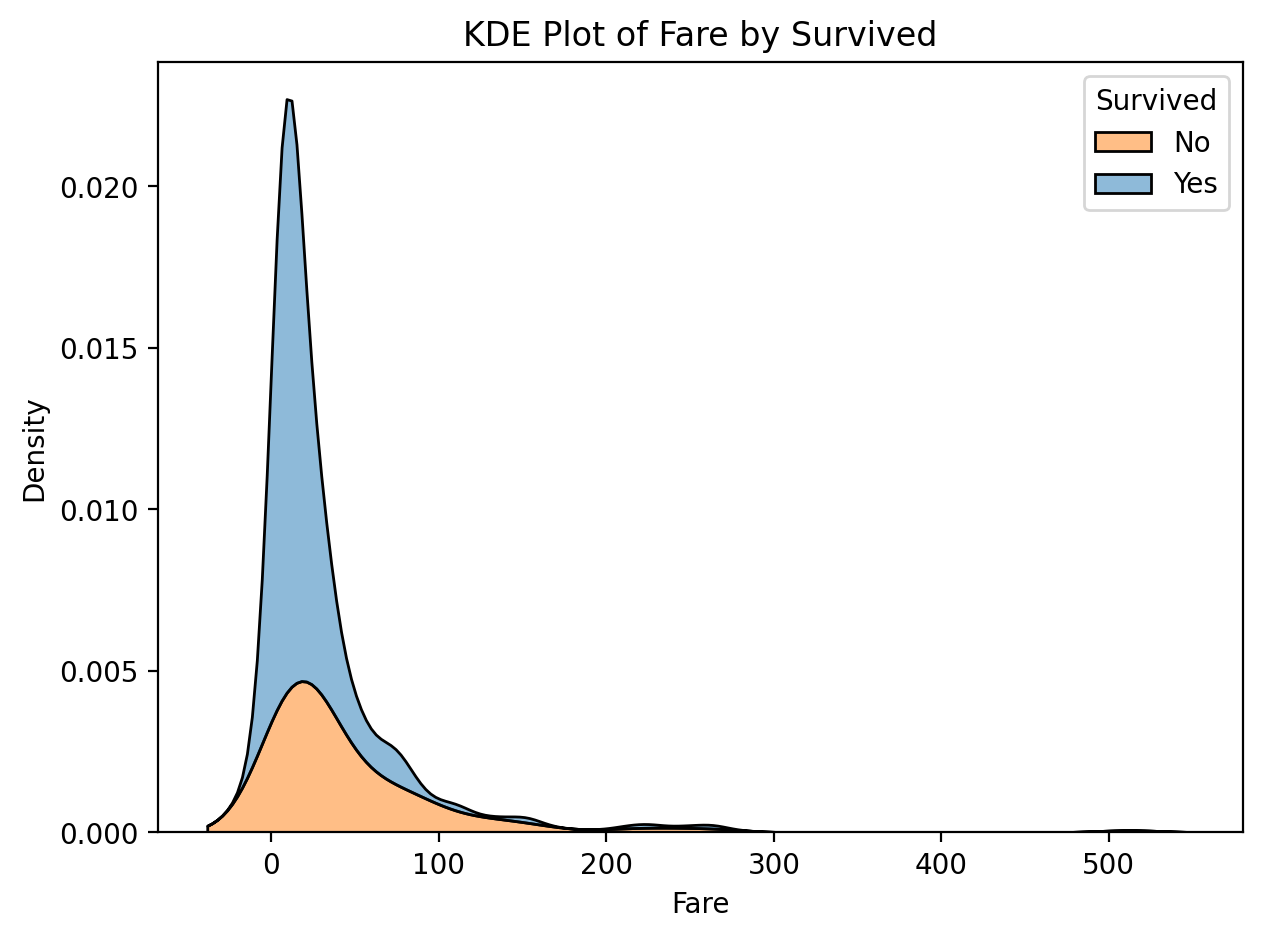

In [20]:
kde_plots(train, numerical_features, target_column)

### Combined Histograms and KDE Plots

In [21]:
def historgram_kde_plots(train, numerical_features, target_column) :
    print("\n--- Combined Histograms and KDE Plots of Numeric Features ---")
    for feature in numerical_features:
        plt.figure(figsize=(10, 6))
        sns.histplot(data=train, x=feature, hue=target_column, kde=True, multiple="stack")
        plt.title(f'Histogram and KDE of {feature} by {target_column}')
        plt.xlabel(feature)
        plt.ylabel('Density / Frequency')
        plt.legend(title=target_column, labels=['No', 'Yes']) # Assuming 0 is 'No', 1 is 'Yes'
        plt.show()


--- Combined Histograms and KDE Plots of Numeric Features ---


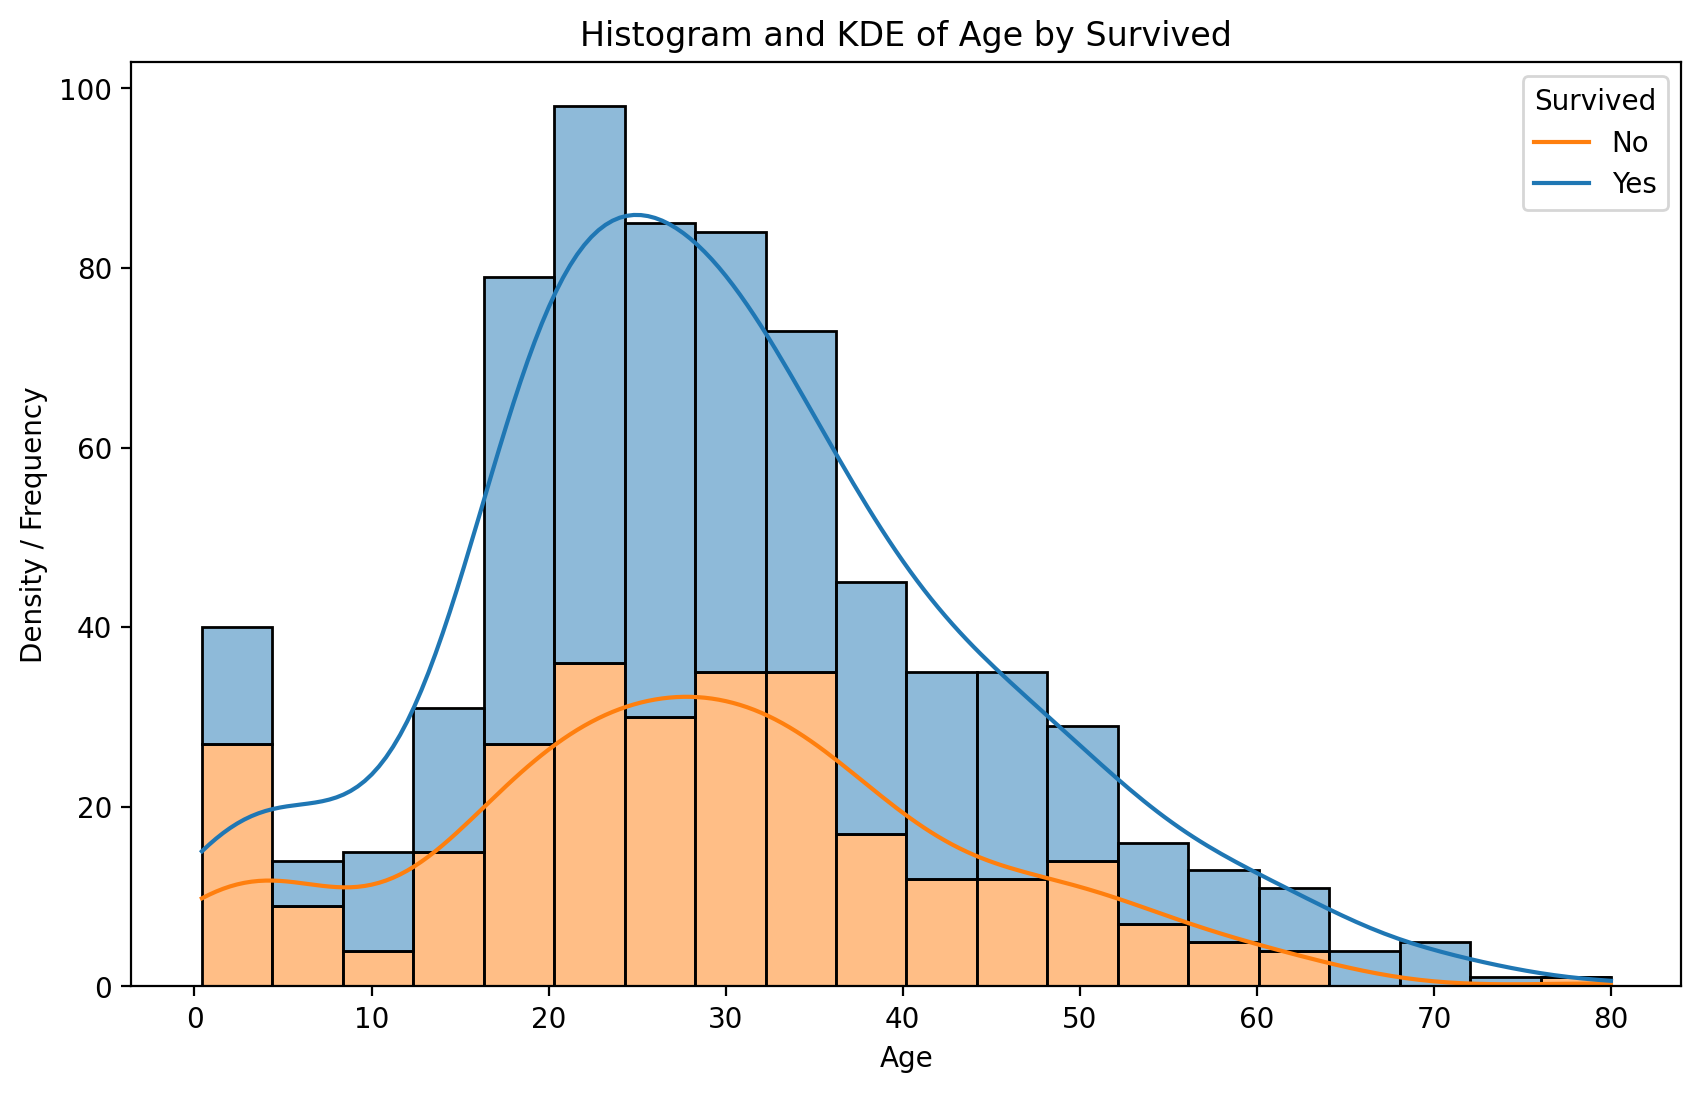

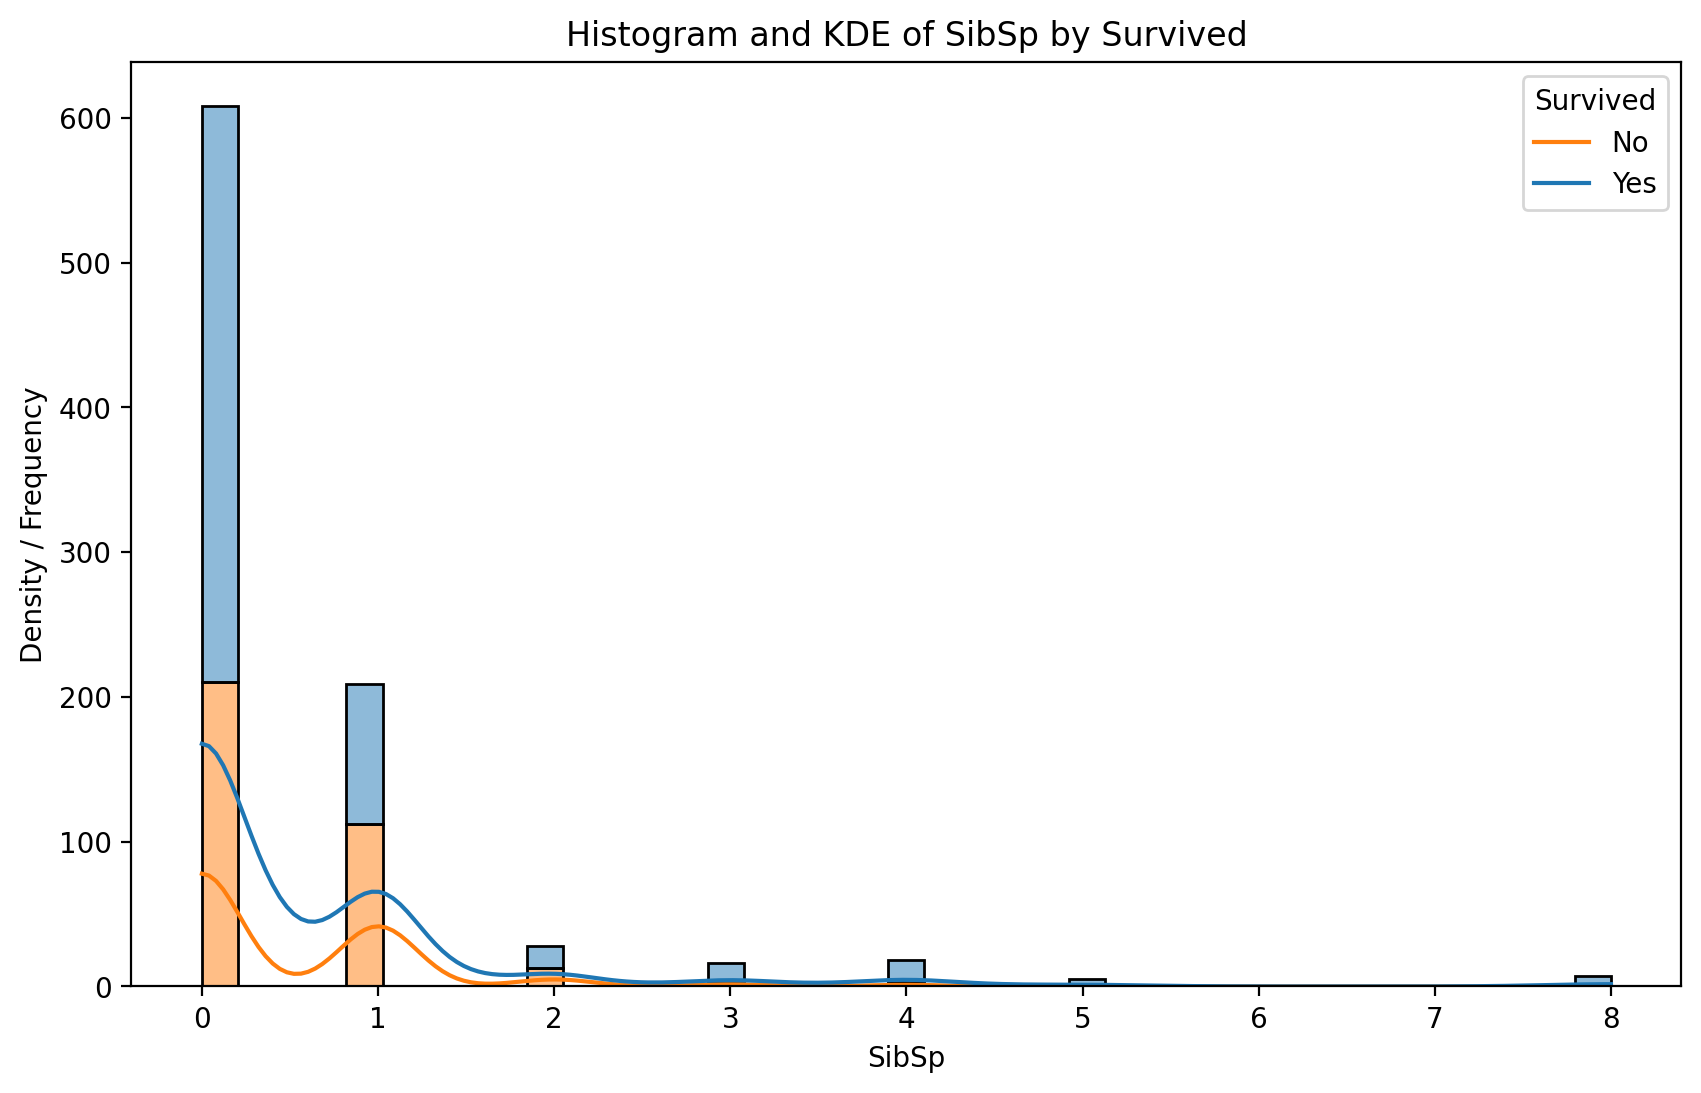

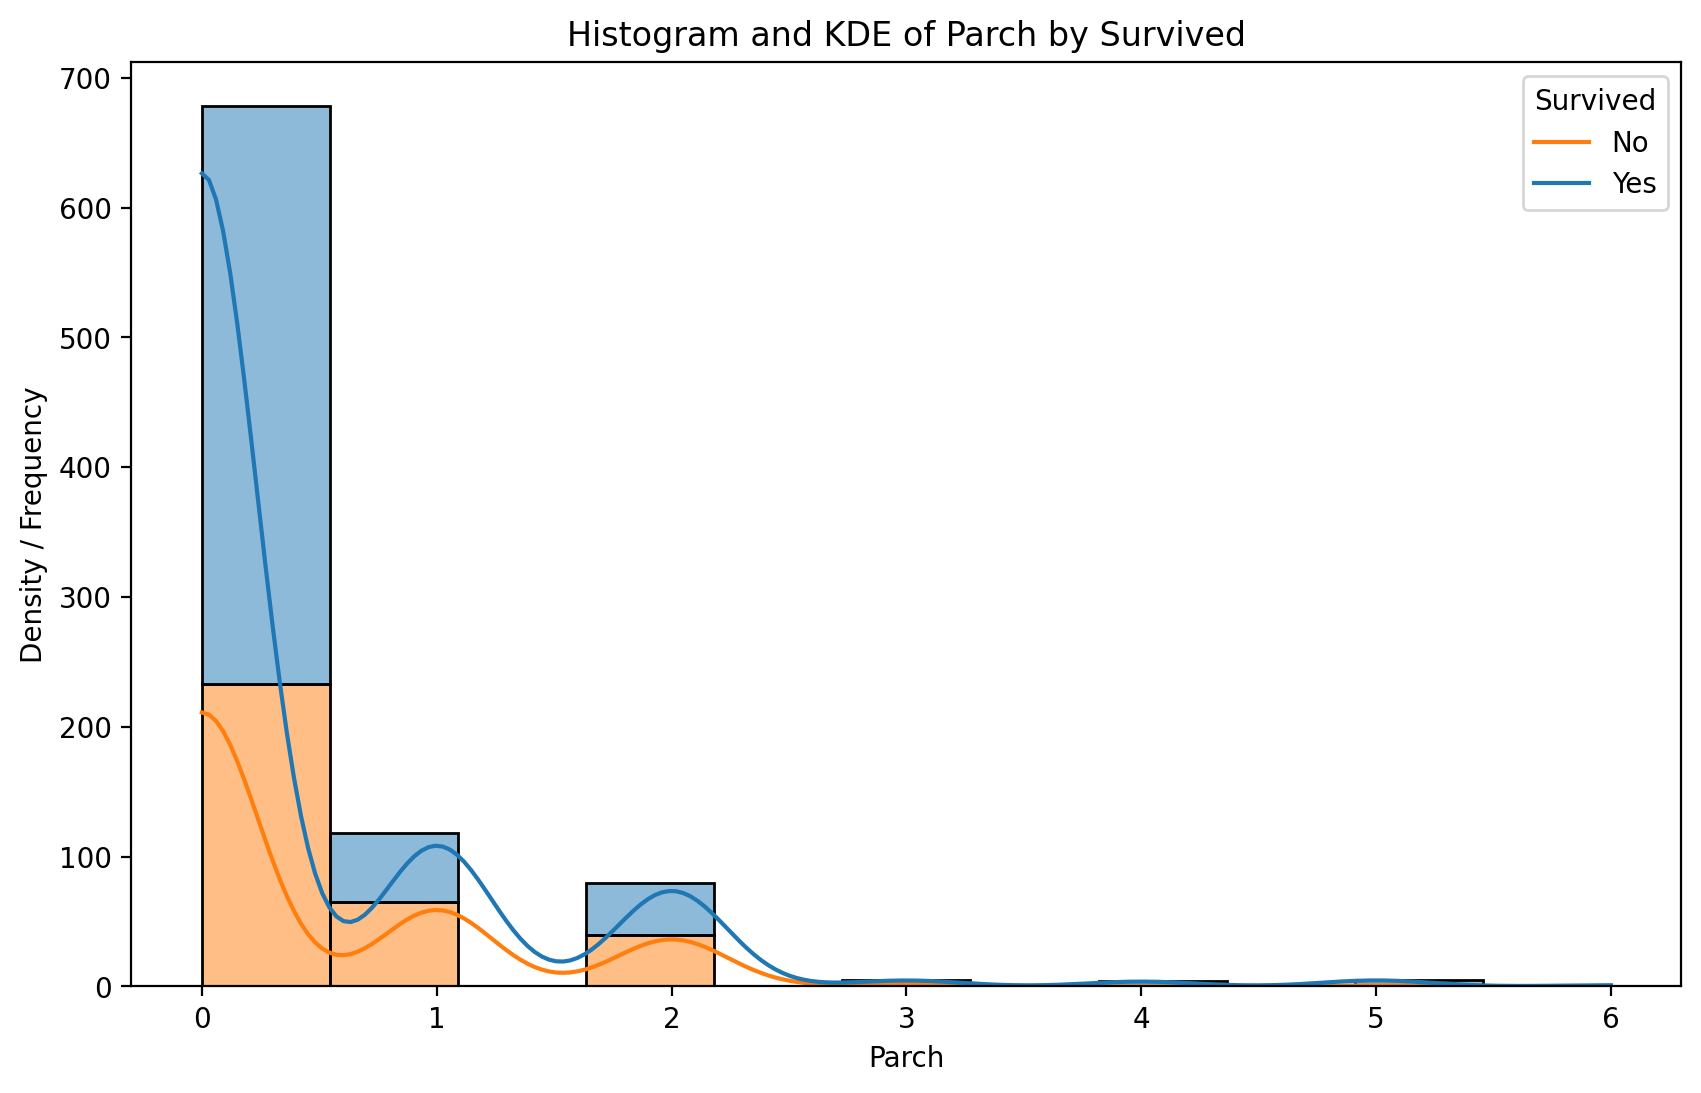

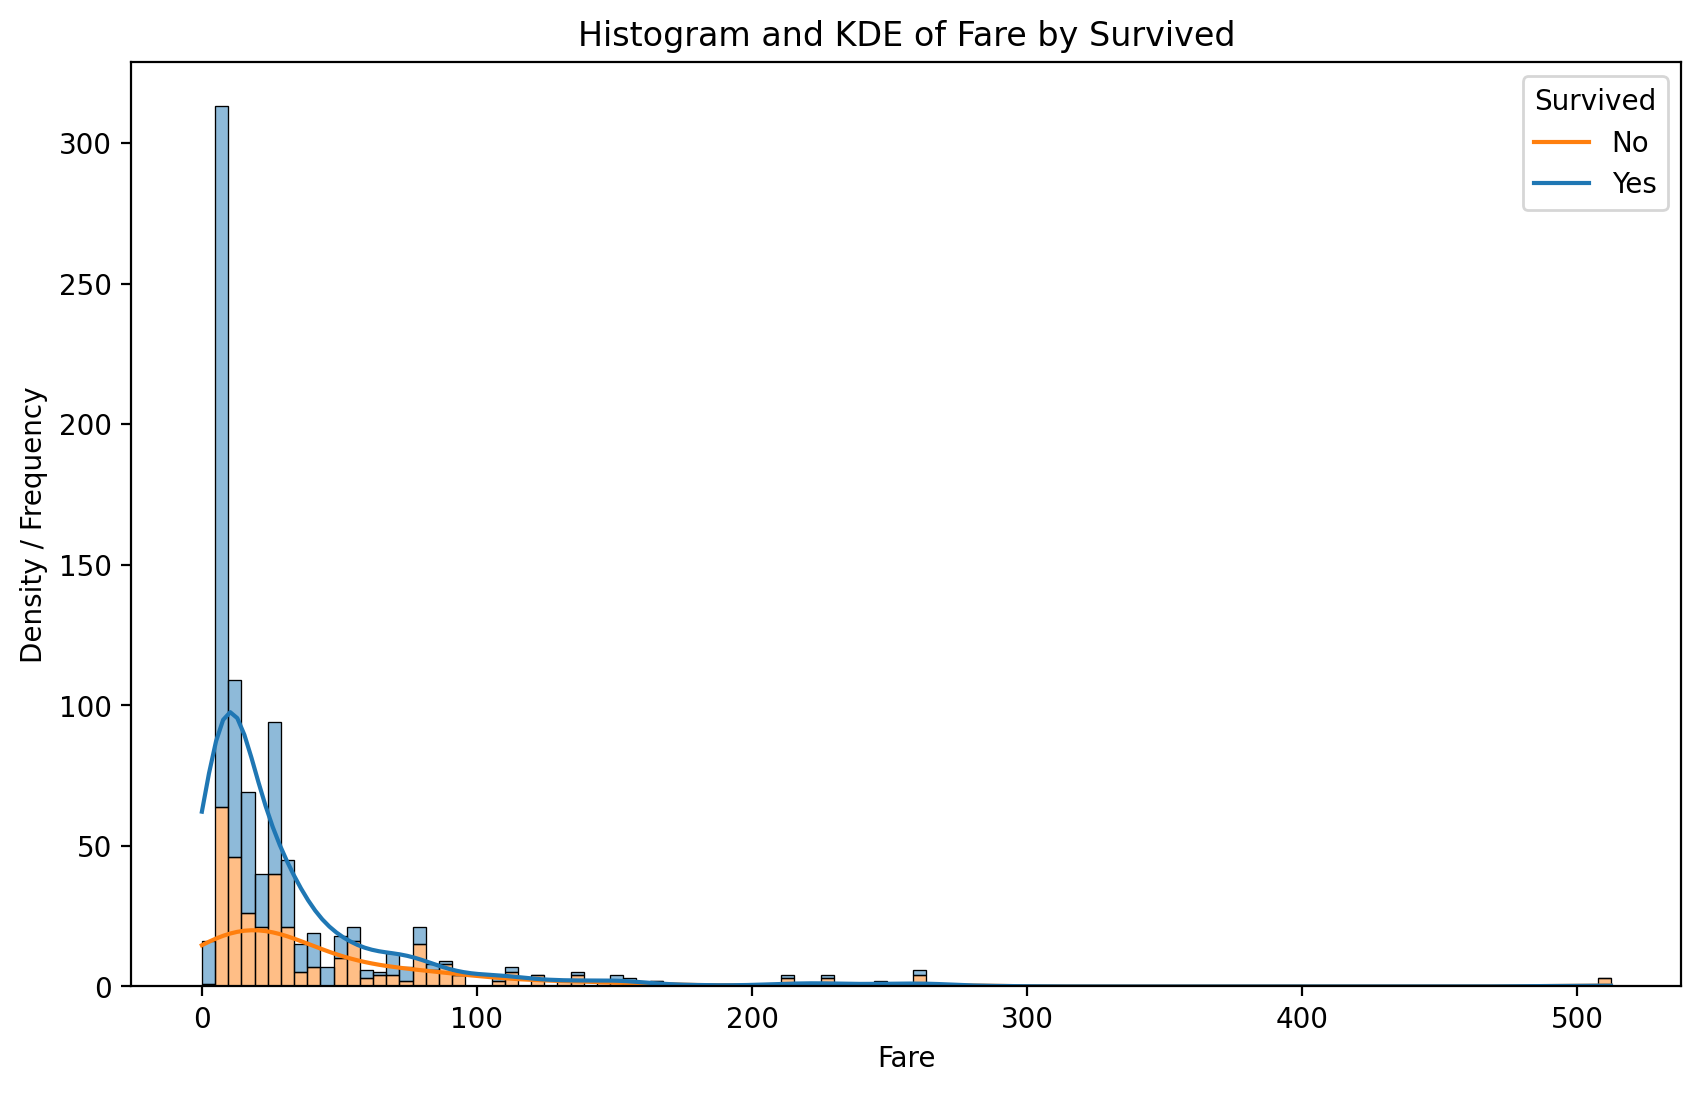

In [22]:
historgram_kde_plots(train, numerical_features, target_column)

### Pair Plots

In [23]:
def pair_plits(train) :
    sns.pairplot(train[['Survived', 'Pclass', 'Age', 'Fare', 'SibSp', 'Parch']], hue='Survived')
    plt.suptitle('Pairwise Relationships of Features', y=1.02)
    plt.show()

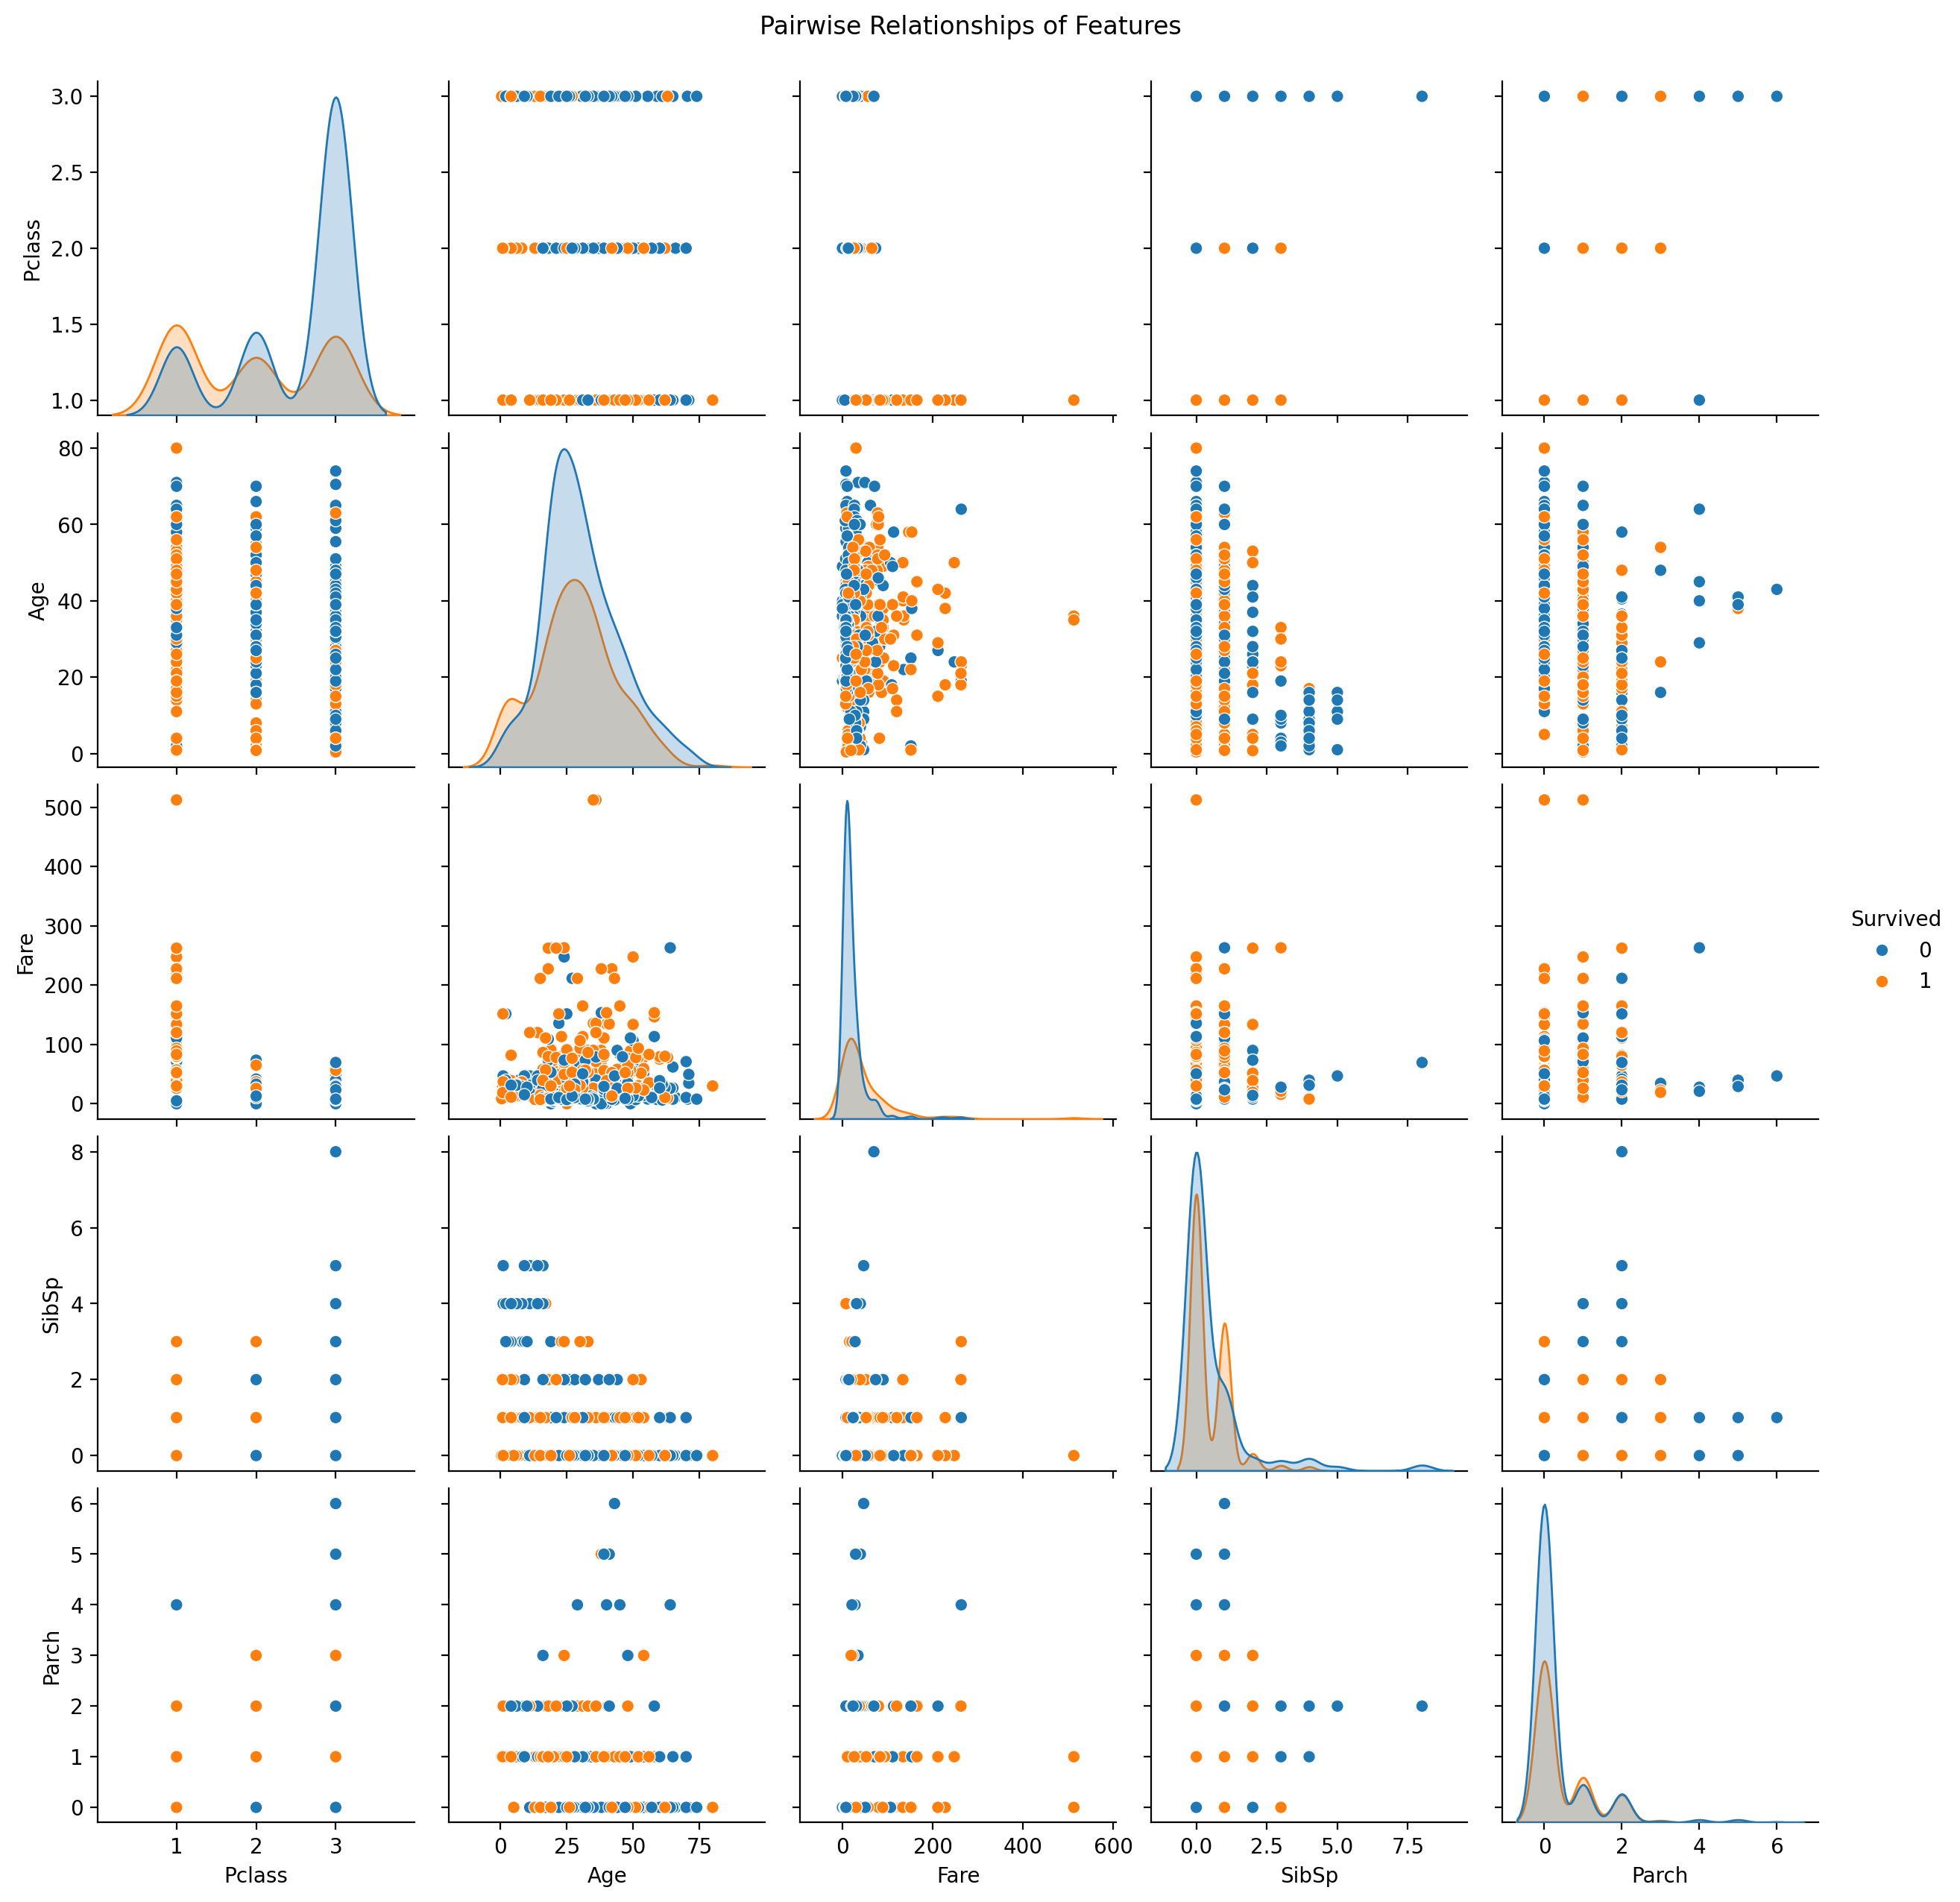

In [24]:
pair_plits(train)

### Target vs. Numerical Feature Analysis

In [25]:
# --- Target vs. Numerical Feature Analysis ---

def box_plots_numerical_features(train, numerical_features, target_column) :

    print("--- Boxplots of Numerical Features by Target ---")
    for feature in numerical_features:
        plt.figure(figsize=(7, 5))
        sns.boxplot(data=train, x=target_column, y=feature, hue=target_column)
        plt.title(f'Boxplot of {feature} by {target_column}')
        plt.xlabel(target_column)
        plt.ylabel(feature)
        plt.xticks([0, 1], ['Negative Class', 'Positive Class'])
        plt.show()
    
    print("\n--- Violin Plots of Numerical Features by Target ---")
    for feature in numerical_features:
        plt.figure(figsize=(7, 5))
        sns.violinplot(data=train, x=target_column, y=feature, split=True, inner="quart")
        plt.title(f'Violin Plot of {feature} by {target_column}')
        plt.xlabel(target_column)
        plt.ylabel(feature)
        plt.xticks([0, 1], ['Negative Class', 'Positive Class'])
        plt.show()

--- Boxplots of Numerical Features by Target ---


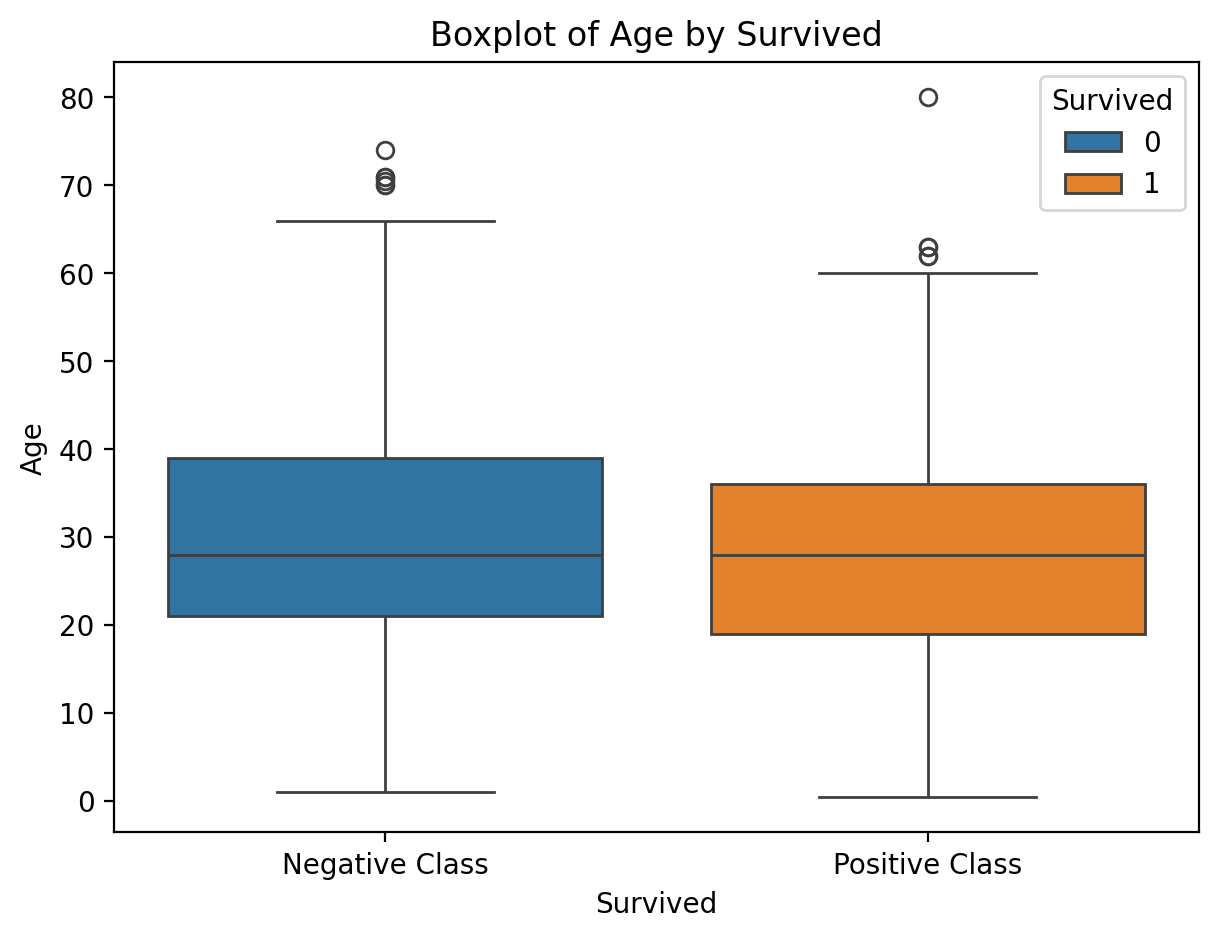

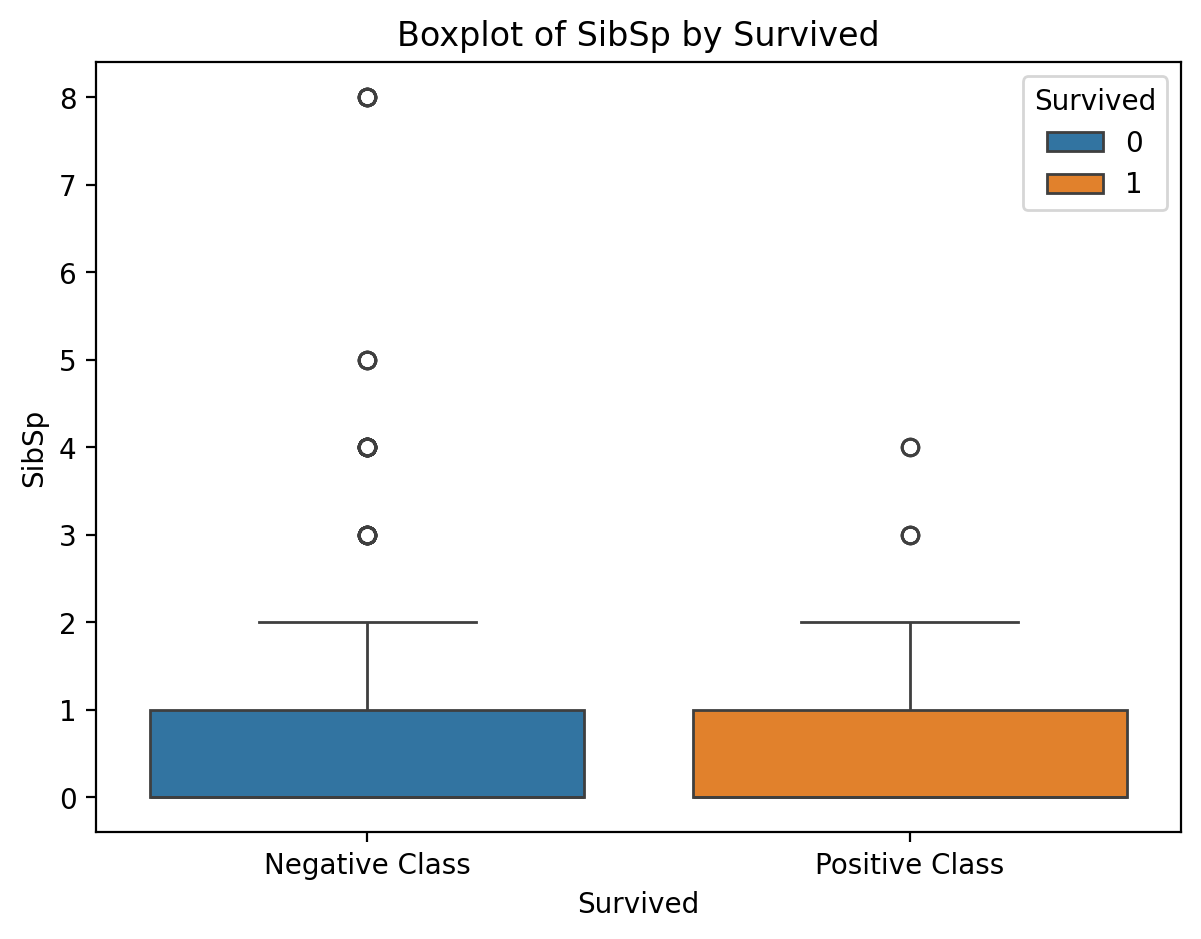

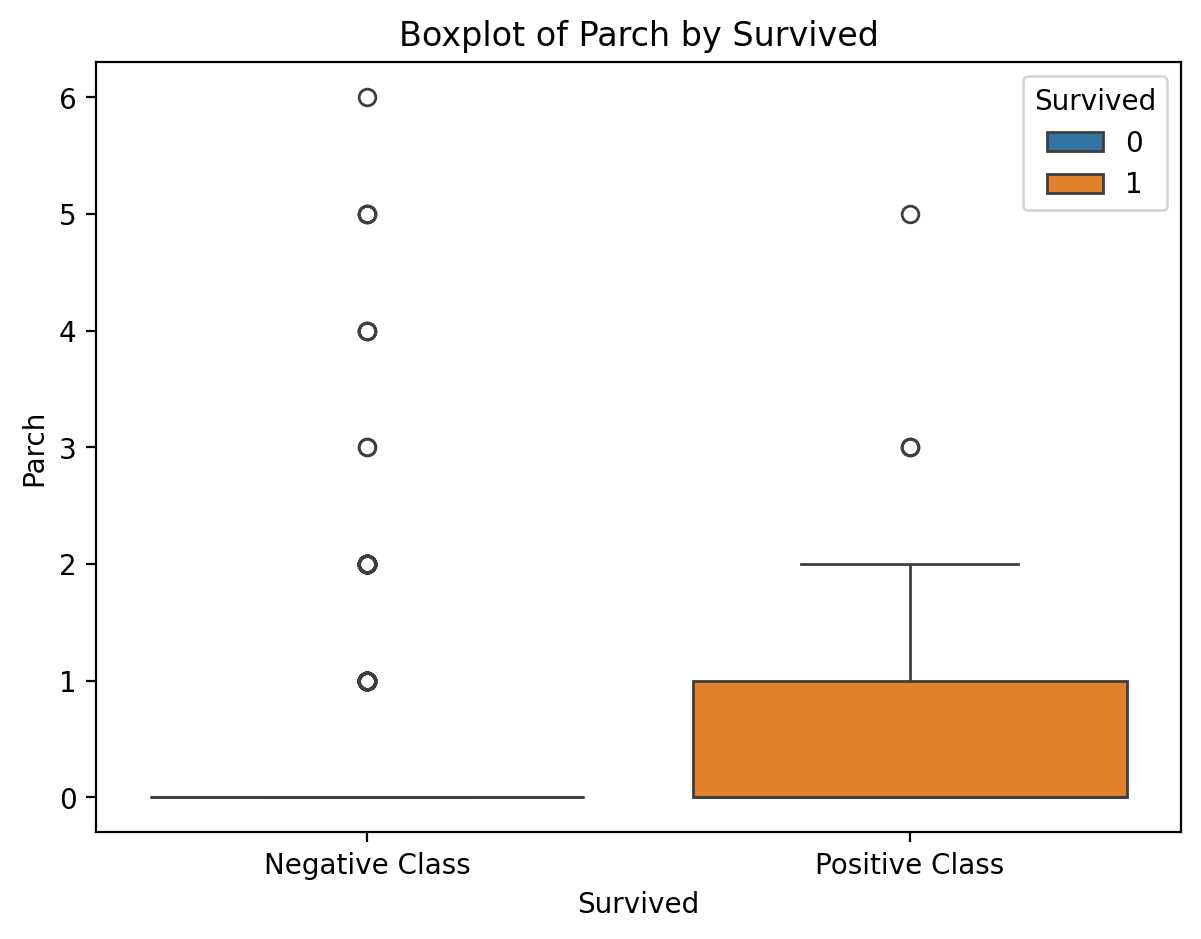

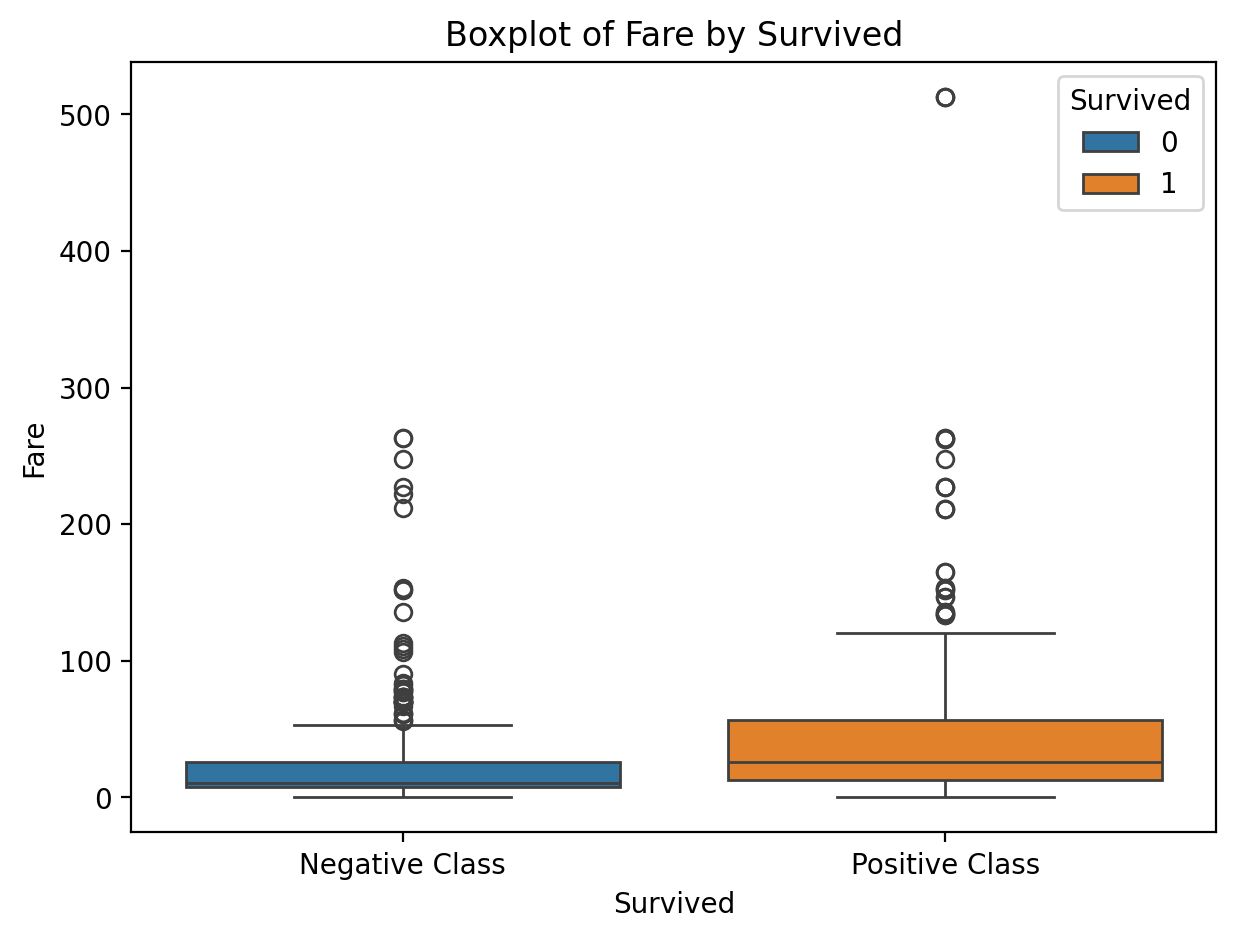


--- Violin Plots of Numerical Features by Target ---


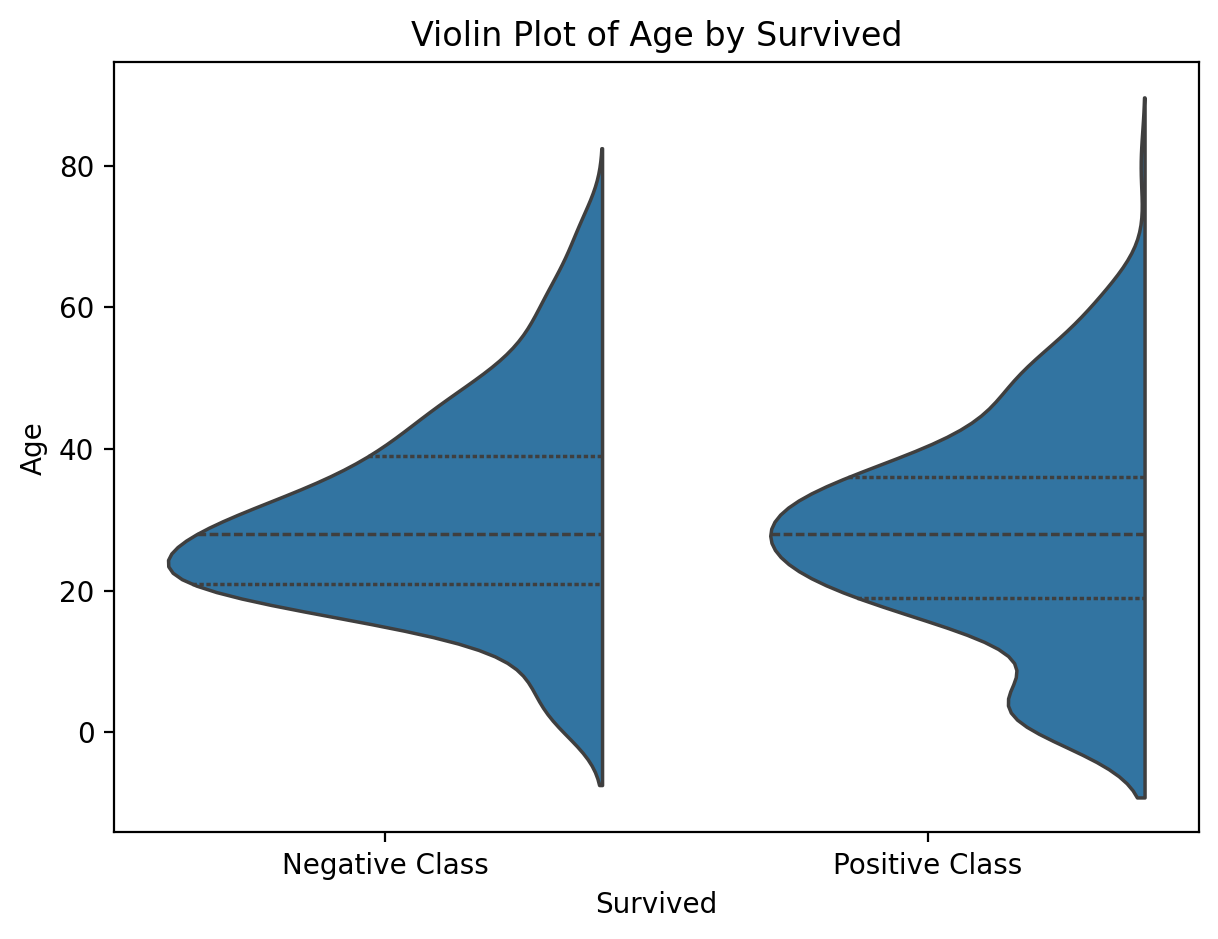

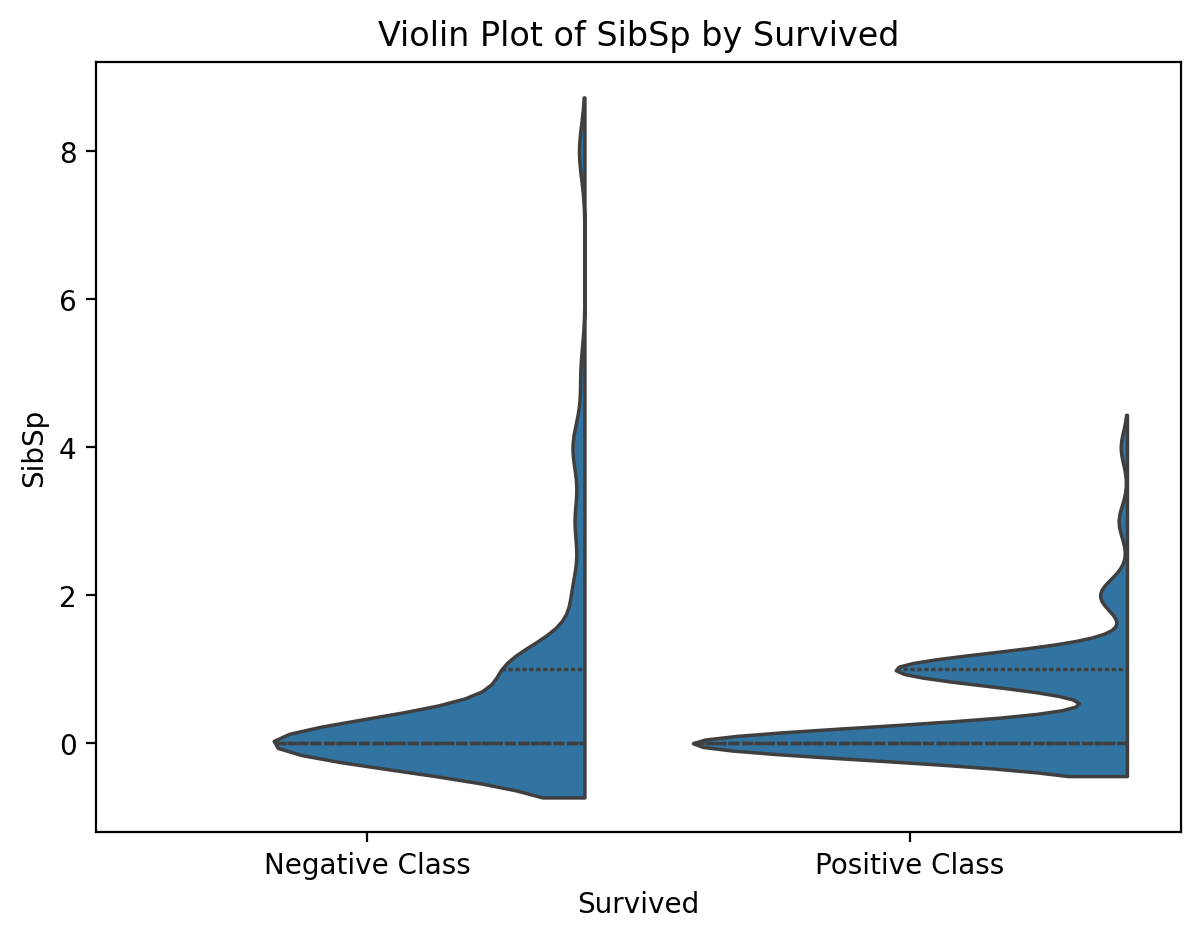

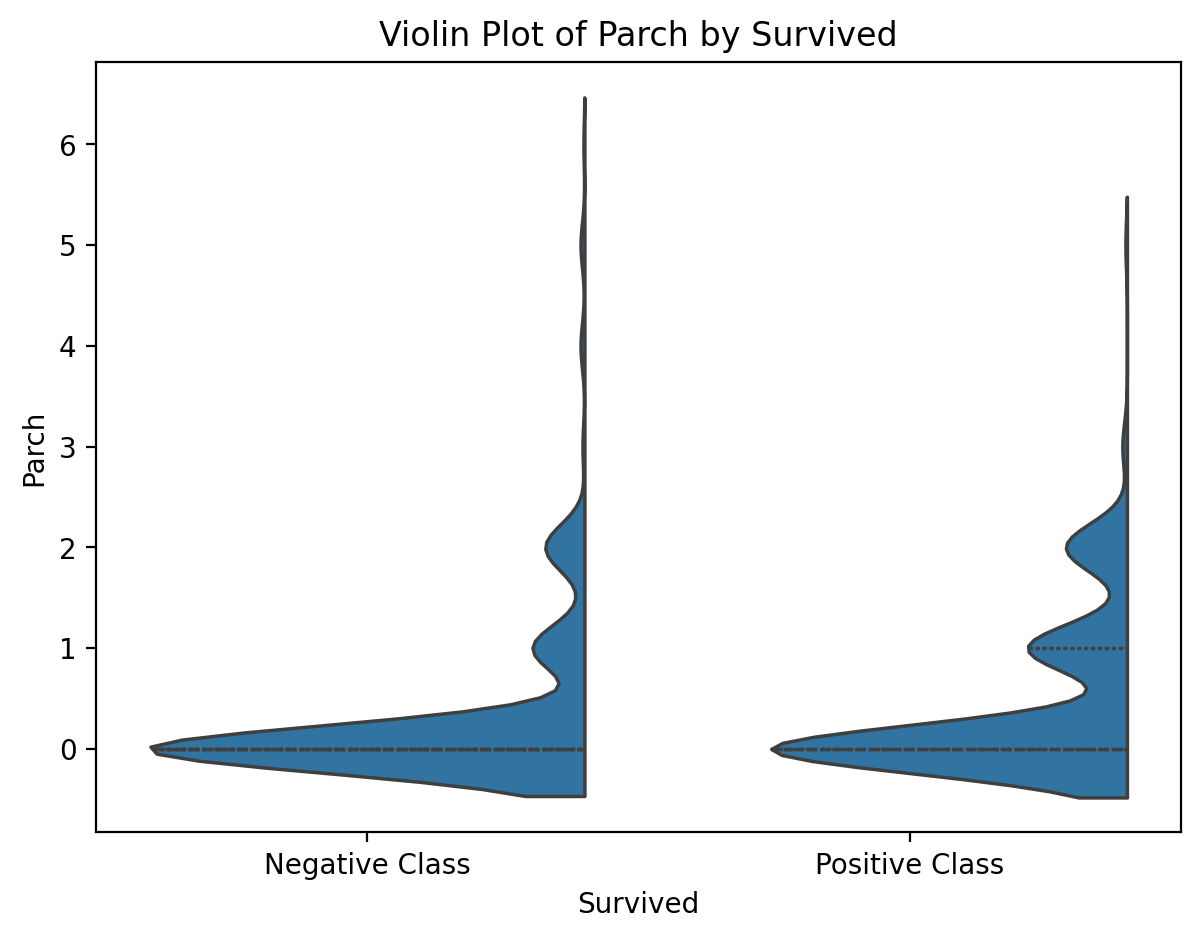

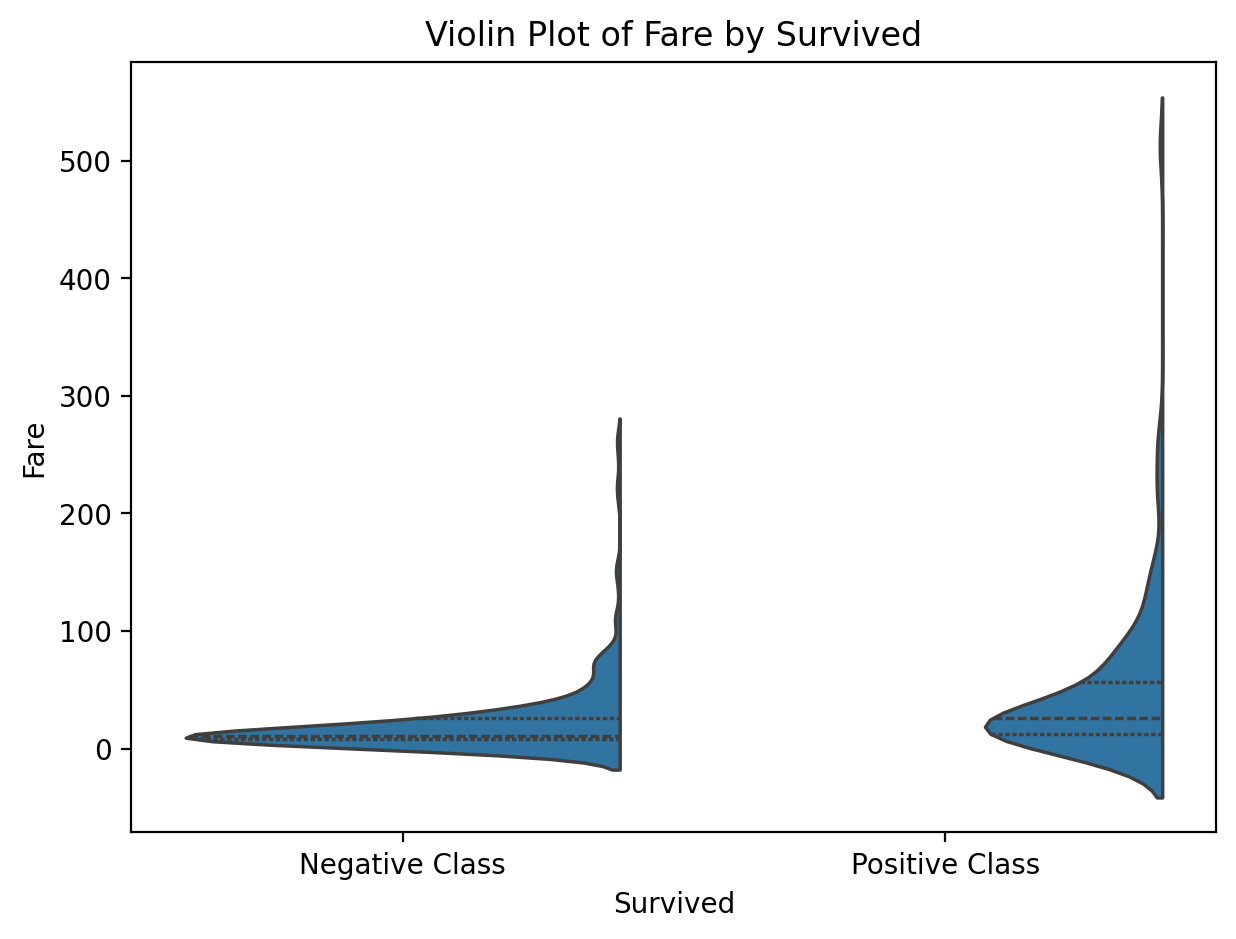

In [26]:
box_plots_numerical_features(train, numerical_features, target_column)

## Feature Engineering

In [27]:
# Fetch all the unique titles from the dataset

all_titles = []

for name_string in train["Name"] :
    comma_pos = name_string.find(',')
    dot_pos = name_string.find('.')
    title = name_string[comma_pos + 2:dot_pos]
    if title not in all_titles :
        all_titles.append(title)

print(all_titles)

['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms', 'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess', 'Jonkheer']


In [28]:
# Function to return the title for a given name
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if big_string.find(substring) != -1:
            return substring
    # print(big_string)
    return np.nan

In [29]:
# Evalute the above function to each row and add it as a column

train['Title']=train['Name'].map(lambda x: substrings_in_string(x, all_titles))
test['Title']=test['Name'].map(lambda x: substrings_in_string(x, all_titles))

#replacing all titles with mr, mrs, miss, master
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Rare_Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title
train['Title']=train.apply(replace_titles, axis=1)
test['Title']=test.apply(replace_titles, axis=1)

categorical_features['Title'] = train['Title']
categorical_features_pred['Title'] = test['Title']
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked Title  
0      0         A/5 21171   7.2500   NaN        S    Mr  
1      0          PC 17599  71.2833   C85        C    Mr  
2      0  STON/O2. 3101282   7.9250   NaN        S  Miss  
3      0            113803  53.1000  C123        S    Mr  
4      0            37345

In [30]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mr
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mr


In [31]:
# Turning cabin number into Deck
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'NaN']

train['Deck']=train['Cabin'].map(lambda x: substrings_in_string(str(x), cabin_list))
test['Deck']=test['Cabin'].map(lambda x: substrings_in_string(str(x), cabin_list))

categorical_features['Deck'] = train['Deck']
categorical_features_pred['Deck'] = test['Deck']
print(train['Deck'].head())

0    NaN
1      C
2    NaN
3      C
4    NaN
Name: Deck, dtype: object


In [32]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,NaN
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mr,NaN
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,NaN
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,NaN
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mr,NaN


In [33]:
# Creating new family_size column
train['Family_Size']=train['SibSp']+train['Parch']+1
test['Family_Size']=test['SibSp']+test['Parch']+1
numerical_features['Family_Size'] = train['Family_Size']

In [34]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,Family_Size
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr,NaN,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mr,NaN,2
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr,NaN,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr,NaN,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mr,NaN,3


In [35]:
categorical_features = categorical_features.drop(columns = ['Cabin','Deck'])
categorical_features_pred = categorical_features_pred.drop(columns = ['Cabin','Deck'])

In [36]:
categorical_features.head(15)

,Sex,Embarked,Pclass,Title
0,male,S,3,Mr
1,female,C,1,Mr
2,female,S,3,Miss
3,female,S,1,Mr
4,male,S,3,Mr
5,male,Q,3,Mr
6,male,S,1,Mr
7,male,S,3,Master
8,female,S,3,Mr
9,female,C,2,Mr


In [37]:
categorical_features_pred.head(15)

,Sex,Embarked,Pclass,Title
0,male,Q,3,Mr
1,female,S,3,Mr
2,male,Q,2,Mr
3,male,S,3,Mr
4,female,S,3,Mr
5,male,S,3,Mr
6,female,Q,3,Miss
7,male,S,2,Mr
8,female,C,3,Mr
9,male,S,3,Mr


In [38]:
numerical_features.head(10)

,Age,SibSp,Parch,Fare,Family_Size
0,22.0,1,0,7.2500,2
1,38.0,1,0,71.2833,2
2,26.0,0,0,7.9250,1
3,35.0,1,0,53.1000,2
4,35.0,0,0,8.0500,1
5,NaN,0,0,8.4583,1
6,54.0,0,0,51.8625,1
7,2.0,3,1,21.0750,5
8,27.0,0,2,11.1333,3
9,14.0,1,0,30.0708,2


In [39]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Deck,Family_Size
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,NaN,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mr,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,NaN,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mr,C,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,NaN,1
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr,NaN,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr,E,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Master,NaN,5
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Mr,NaN,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Mr,NaN,2


In [40]:
train = train.drop(columns = ['Name','Ticket','PassengerId','Cabin','Deck'])
test = test.drop(columns = ['Name','Ticket','PassengerId','Cabin','Deck'])

In [41]:
train.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family_Size
0,0,3,male,22.0,1,0,7.2500,S,Mr,2
1,1,1,female,38.0,1,0,71.2833,C,Mr,2
2,1,3,female,26.0,0,0,7.9250,S,Miss,1
3,1,1,female,35.0,1,0,53.1000,S,Mr,2
4,0,3,male,35.0,0,0,8.0500,S,Mr,1
5,0,3,male,NaN,0,0,8.4583,Q,Mr,1
6,0,1,male,54.0,0,0,51.8625,S,Mr,1
7,0,3,male,2.0,3,1,21.0750,S,Master,5
8,1,3,female,27.0,0,2,11.1333,S,Mr,3
9,1,2,female,14.0,1,0,30.0708,C,Mr,2


In [42]:
test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family_Size
0,3,male,34.5,0,0,7.8292,Q,Mr,1
1,3,female,47.0,1,0,7.0000,S,Mr,2
2,2,male,62.0,0,0,9.6875,Q,Mr,1
3,3,male,27.0,0,0,8.6625,S,Mr,1
4,3,female,22.0,1,1,12.2875,S,Mr,3


In [43]:
def encode_categorical_features(categorical_features) :
    # label_encoders = {}
    X_encoded = categorical_features.copy()
    i = 0
    for col in categorical_features:
        print(categorical_features.columns[i])
        # le = skl.preprocessing.LabelEncoder()
        # X_encoded[col] = le.fit_transform(X_encoded[col])
        # label_encoders[col] = le
        X_encoded_dummies = pd.get_dummies(categorical_features[col], prefix=categorical_features.columns[i])
        X_encoded = pd.concat([X_encoded, X_encoded_dummies], axis=1)
        X_encoded.drop(col, axis=1, inplace=True)
        i += 1
        
    return X_encoded

In [44]:
# print(type(categorical_features_pred))
# categorical_features_pred = categorical_features_pred.to_frame()
# print(type(categorical_features_pred))
# categorical_features_pred.head()

In [45]:
X = train.drop([target_column], axis=1)
X_Pred = test
print(type(X_Pred))
y = train[target_column]
categorical_features_encoded = encode_categorical_features(categorical_features)
categorical_features_encoded_pred = encode_categorical_features(categorical_features_pred)
categorical_features_encoded.head()

<class 'pandas.core.frame.DataFrame'>
Sex
Embarked
Pclass
Title
Sex
Embarked
Pclass
Title


,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare_Mr,Title_the Countess
0,False,True,False,False,True,False,False,True,False,False,True,False,False,False
1,True,False,True,False,False,True,False,False,False,False,True,False,False,False
2,True,False,False,False,True,False,False,True,False,True,False,False,False,False
3,True,False,False,False,True,True,False,False,False,False,True,False,False,False
4,False,True,False,False,True,False,False,True,False,False,True,False,False,False


In [46]:
X = pd.concat([train, categorical_features_encoded], axis=1)
X_Pred = pd.concat([test, categorical_features_encoded_pred], axis=1)
X.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family_Size,...,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare_Mr,Title_the Countess
0,0,3,male,22.0,1,0,7.2500,S,Mr,2,...,True,False,False,True,False,False,True,False,False,False
1,1,1,female,38.0,1,0,71.2833,C,Mr,2,...,False,True,False,False,False,False,True,False,False,False
2,1,3,female,26.0,0,0,7.9250,S,Miss,1,...,True,False,False,True,False,True,False,False,False,False
3,1,1,female,35.0,1,0,53.1000,S,Mr,2,...,True,True,False,False,False,False,True,False,False,False
4,0,3,male,35.0,0,0,8.0500,S,Mr,1,...,True,False,False,True,False,False,True,False,False,False


In [47]:
# Add new feature Is_Alone

X['Is_Alone'] = False
X.loc[X['Family_Size'] == 1, 'Is_Alone'] = True

X_Pred['Is_Alone'] = False
X_Pred.loc[X_Pred['Family_Size'] == 1, 'Is_Alone'] = True

In [48]:
X.isna().sum()

Survived                0
Pclass                  0
Sex                     0
Age                   177
SibSp                   0
Parch                   0
Fare                    0
Embarked                2
Title                   0
Family_Size             0
Sex_female              0
Sex_male                0
Embarked_C              0
Embarked_Q              0
Embarked_S              0
Pclass_1                0
Pclass_2                0
Pclass_3                0
Title_Master            0
Title_Miss              0
Title_Mr                0
Title_Mrs               0
Title_Rare_Mr           0
Title_the Countess      0
Is_Alone                0
dtype: int64

In [49]:
X_Pred.isna().sum()

Pclass            0
Sex               0
Age              86
SibSp             0
Parch             0
Fare              1
Embarked          0
Title             0
Family_Size       0
Sex_female        0
Sex_male          0
Embarked_C        0
Embarked_Q        0
Embarked_S        0
Pclass_1          0
Pclass_2          0
Pclass_3          0
Title_Master      0
Title_Miss        0
Title_Mr          0
Title_Mrs         0
Title_Rare_Mr     0
Is_Alone          0
dtype: int64

In [50]:
X['Age_Missing'] = X['Age'].isnull().astype(int)
X_Pred['Age_Missing'] = X_Pred['Age'].isnull().astype(int)

Impute with median

In [51]:
# # Handling the missing values

# import warnings
# warnings.filterwarnings("ignore")

# def impute_age(cols):
#     Age = cols[0]
#     Pclass = cols[1]

#     if pd.isnull(Age):
#         if Pclass == 1:
#             return X[X['Pclass'] == 1]['Age'].median()
#         elif Pclass == 2:
#             return X[X['Pclass'] == 2]['Age'].median()
#         else:
#             return X[X['Pclass'] == 3]['Age'].median()
#     return Age

# X['Age'] = X[['Age', 'Pclass']].apply(impute_age, axis=1)
# X_Pred['Age'] = X_Pred[['Age', 'Pclass']].apply(impute_age, axis=1)

# print(f"Number of NaN values in Age after Pclass-based imputation: {X['Age'].isna().sum()}")
# print(f"Number of NaN values in Age after Pclass-based imputation: {X_Pred['Age'].isna().sum()}")

In [52]:
# X = X.drop(columns=['Survived','Sex','Pclass','Title'])
# X_Pred = X_Pred.drop(columns=['Sex','Pclass','Title'])

In [53]:
# # Get indices of rows with missing 'Embarked' values
# dropped_indices = X[X['Embarked'].isna()].index

# # Drop rows from X
# X.dropna(subset=['Embarked'], inplace=True)

# # Drop corresponding rows from y using the same indices
# y.drop(index=dropped_indices, inplace=True)
# categorical_features_encoded.drop(index=dropped_indices, inplace=True)

In [54]:
# X = X.drop(columns=['Embarked'])
# X_Pred = X_Pred.drop(columns=['Embarked'])
# X.drop(columns=['Title_the Countess'], inplace=True)

Using Regression for missing values

In [55]:
# Fill Embarked with mode

X['Embarked'] = X['Embarked'].fillna(X['Embarked'].mode()[0])

In [56]:
X.drop(columns=['Title_the Countess'], inplace=True)

In [57]:
X = X.drop(columns=['Survived','Sex','Embarked','Pclass','Title'])
X_Pred = X_Pred.drop(columns=['Sex','Embarked','Pclass','Title'])

In [58]:
# Impute Values using Random Forest Regression

def impute_age(X, X_Pred) :
    
    Known_Age_X = X[X['Age'].notnull()]
    Unknown_Age_X = X[X['Age'].isnull()]
    Unknown_Age_X_Pred = X_Pred[X_Pred['Age'].isnull()]
    
    Known_Age_y = Known_Age_X['Age']
    Known_Age_X.drop(columns=['Age'], inplace=True)
    Unknown_Age_X.drop(columns=['Age'], inplace=True)
    Unknown_Age_X_Pred.drop(columns=['Age'], inplace=True)
    
    print("\nTraining RandomForestRegressor to predict missing 'Age' values...")
    rfr = skl.ensemble.RandomForestRegressor(n_estimators=100, random_state=42)
    rfr.fit(Known_Age_X, Known_Age_y)
    print("Training complete.")
    predicted_ages_X = rfr.predict(Unknown_Age_X)
    X.loc[X['Age'].isnull(), 'Age'] = predicted_ages_X

    predicted_ages_X_Pred = rfr.predict(Unknown_Age_X_Pred)
    X_Pred.loc[X_Pred['Age'].isnull(), 'Age'] = predicted_ages_X_Pred
    
    print("\nMissing Age values after imputation:", X['Age'].isnull().sum())
    print("Shape of X after age imputation:", X.shape)

    print("\nMissing Age values after imputation:", X_Pred['Age'].isnull().sum())
    print("Shape of X_Pred after age imputation:", X_Pred.shape)

impute_age(X, X_Pred)


Training RandomForestRegressor to predict missing 'Age' values...
Training complete.

Missing Age values after imputation: 0
Shape of X after age imputation: (891, 20)

Missing Age values after imputation: 0
Shape of X_Pred after age imputation: (418, 20)


In [59]:
X.isna().sum()

Age              0
SibSp            0
Parch            0
Fare             0
Family_Size      0
Sex_female       0
Sex_male         0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
Pclass_1         0
Pclass_2         0
Pclass_3         0
Title_Master     0
Title_Miss       0
Title_Mr         0
Title_Mrs        0
Title_Rare_Mr    0
Is_Alone         0
Age_Missing      0
dtype: int64

In [60]:
X_Pred.isna().sum()

Age              0
SibSp            0
Parch            0
Fare             1
Family_Size      0
Sex_female       0
Sex_male         0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
Pclass_1         0
Pclass_2         0
Pclass_3         0
Title_Master     0
Title_Miss       0
Title_Mr         0
Title_Mrs        0
Title_Rare_Mr    0
Is_Alone         0
Age_Missing      0
dtype: int64

In [61]:
# Fill missing 'Fare' with mean

X_Pred['Fare'] = X_Pred['Fare'].fillna(X_Pred['Fare'].mean())

### Mutual Information Scores

In [62]:
print(X.shape)
print(y.shape)
print(y.index.equals(X.index))  # Should return True

(891, 20)
(891,)
True


In [63]:
print(X_Pred.shape)

(418, 20)


In [64]:
def mutual_information_scores(X, y) :
    # Calculate Mutual Information Scores
    mutual_info = skl.feature_selection.mutual_info_classif(categorical_features_encoded, y, random_state=42)
    
    # Create a Series of Feature Names and their MI Scores
    mi_scores = pd.Series(mutual_info, index=categorical_features_encoded.columns)
    
    # Sort the MI scores in descending order
    mi_scores_sorted = mi_scores.sort_values(ascending=False)
    
    # Display the Mutual Information Scores
    print("--- Feature-Target Mutual Information Scores ---")
    print(mi_scores_sorted)

In [65]:
mutual_information_scores(X, y)

--- Feature-Target Mutual Information Scores ---
Sex_male              0.148940
Sex_female            0.139787
Title_Miss            0.076016
Pclass_3              0.059671
Pclass_1              0.044923
Title_Mr              0.041085
Title_Master          0.028512
Embarked_C            0.018298
Embarked_S            0.003686
Title_the Countess    0.000907
Embarked_Q            0.000000
Pclass_2              0.000000
Title_Mrs             0.000000
Title_Rare_Mr         0.000000
dtype: float64


### Target vs. Categorical Feature Analysis (using Barplots for proportions)

In [66]:
def bar_plots_categorical_features(train, categorical_features, target_column) :
    print("\n--- Bar Plots of Target Proportions by Categorical Features ---")
    for feature in categorical_features:
        category_proportions = train.groupby(feature)[target_column].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()
        plt.figure(figsize=(7, 5))
        sns.barplot(data=category_proportions, x=feature, y='Percentage', hue=target_column)
        plt.title(f'Proportion of {target_column} by {feature}')
        plt.xlabel(feature)
        plt.ylabel('Percentage (%)')
        plt.legend(title=target_column, labels=['Negative Class', 'Positive Class'])
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


--- Bar Plots of Target Proportions by Categorical Features ---


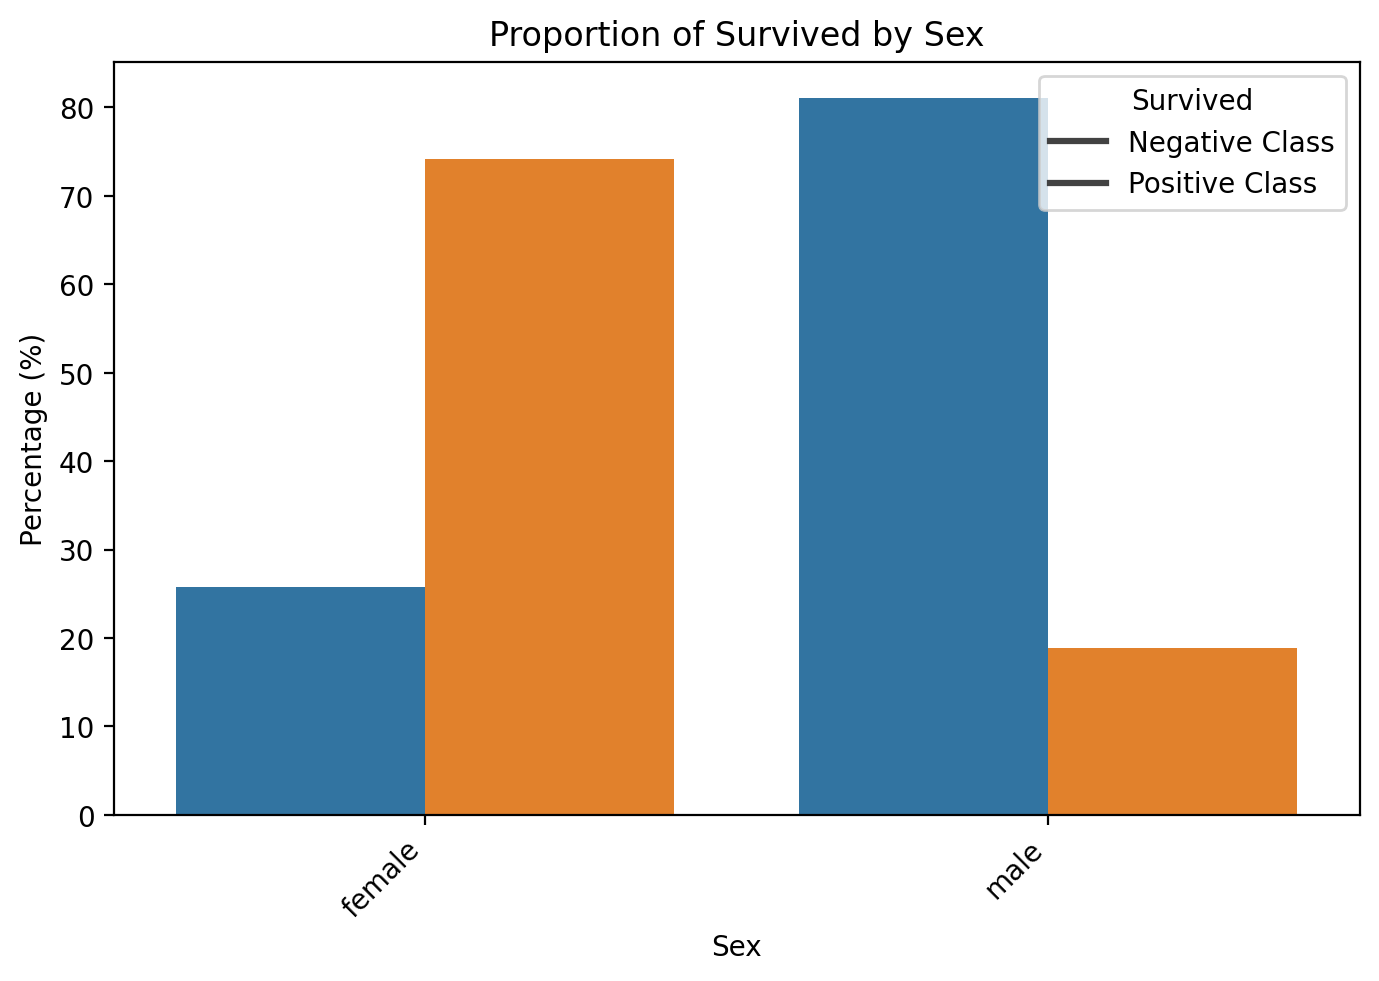

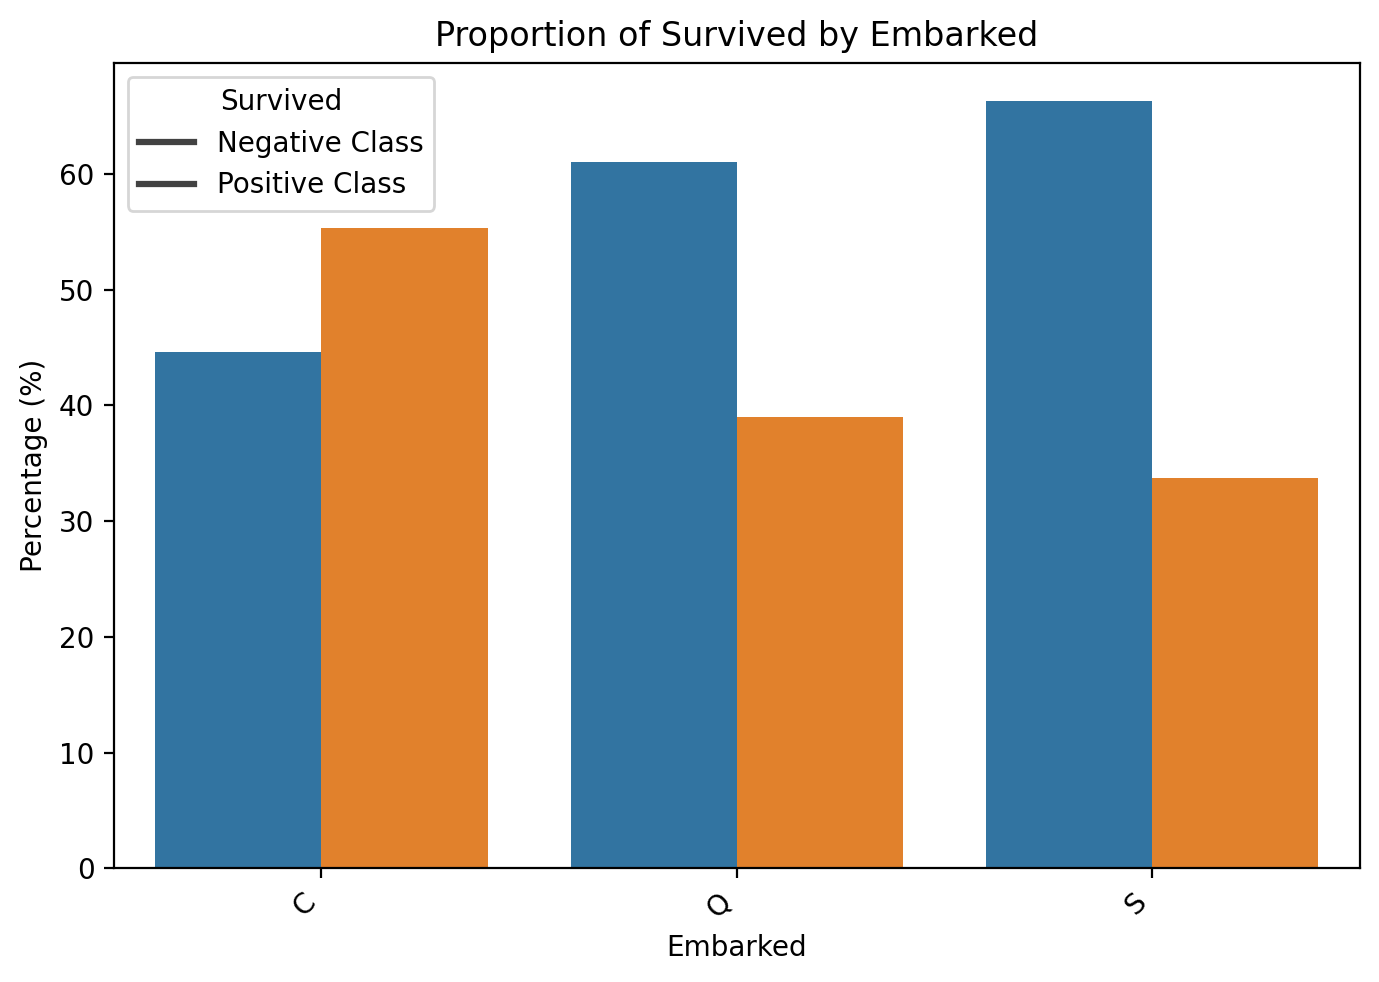

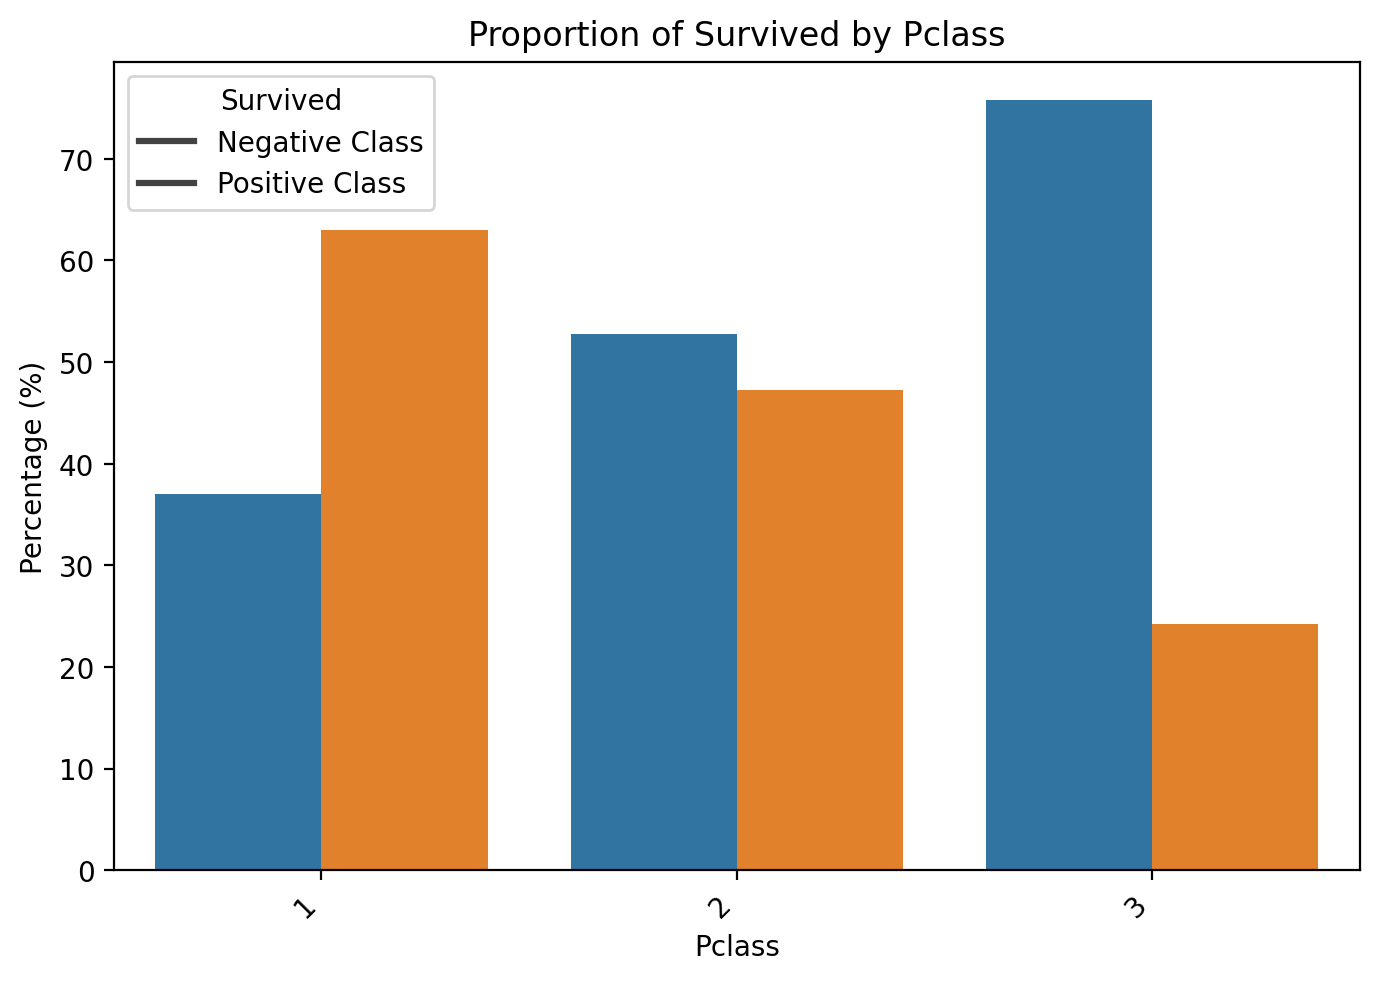

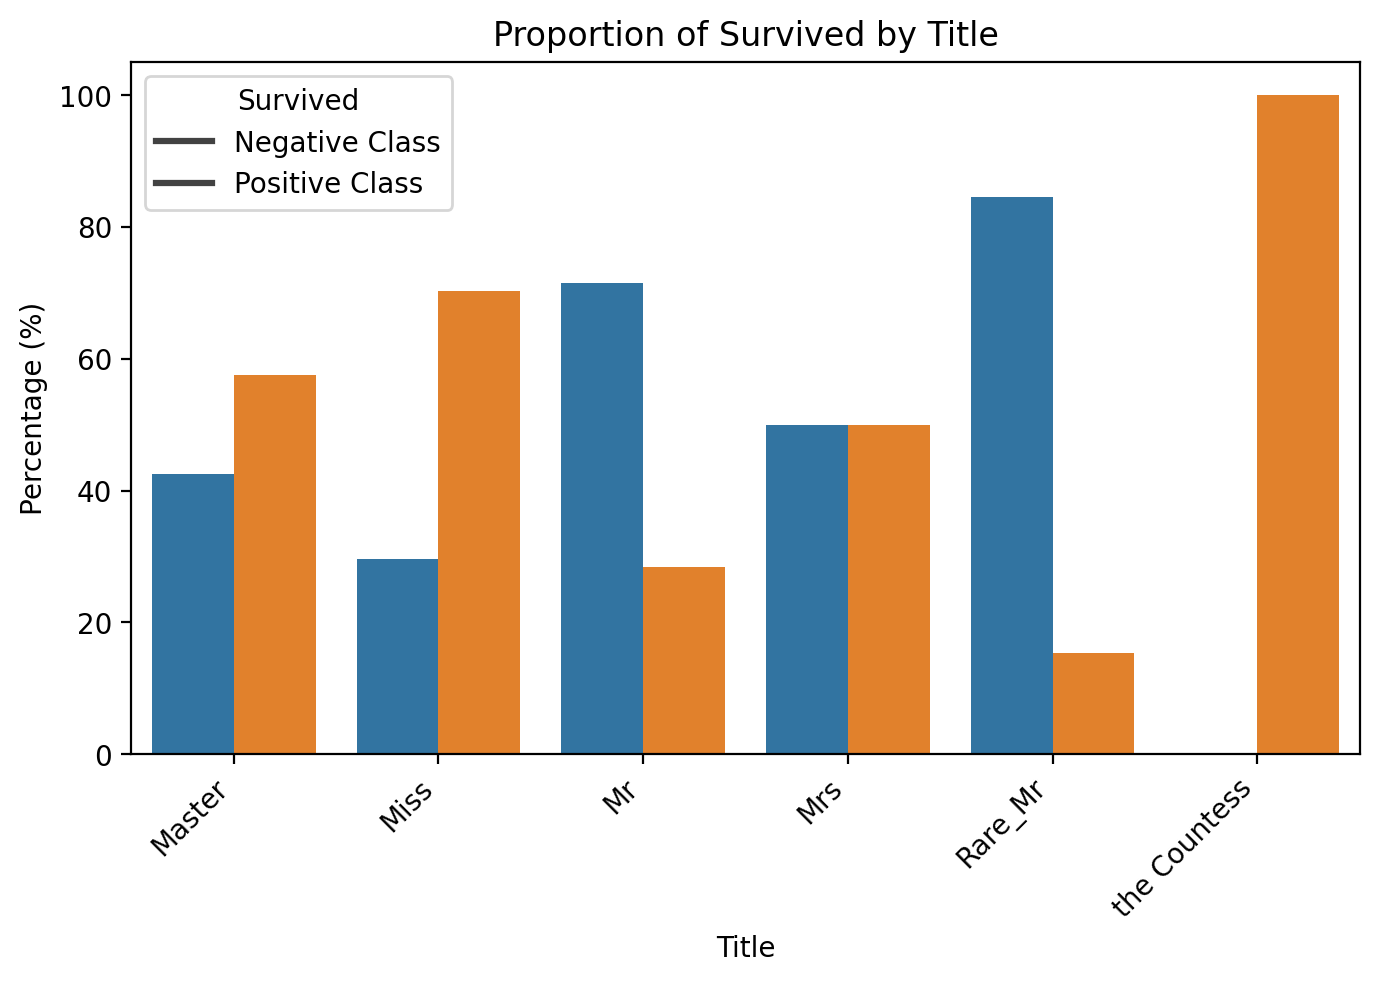

In [67]:
bar_plots_categorical_features(train, categorical_features, target_column)

In [68]:
categorical_features.head()

,Sex,Embarked,Pclass,Title
0,male,S,3,Mr
1,female,C,1,Mr
2,female,S,3,Miss
3,female,S,1,Mr
4,male,S,3,Mr


In [69]:
# X = X.drop(columns=['Survived','Sex','Embarked','Pclass','Title'])
# X_Pred = X_Pred.drop(columns=['Sex','Embarked','Pclass','Title'])

In [70]:
X.head()

,Age,SibSp,Parch,Fare,Family_Size,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare_Mr,Is_Alone,Age_Missing
0,22.0,1,0,7.2500,2,False,True,False,False,True,False,False,True,False,False,True,False,False,False,0
1,38.0,1,0,71.2833,2,True,False,True,False,False,True,False,False,False,False,True,False,False,False,0
2,26.0,0,0,7.9250,1,True,False,False,False,True,False,False,True,False,True,False,False,False,True,0
3,35.0,1,0,53.1000,2,True,False,False,False,True,True,False,False,False,False,True,False,False,False,0
4,35.0,0,0,8.0500,1,False,True,False,False,True,False,False,True,False,False,True,False,False,True,0


In [71]:
X_Pred.head()

,Age,SibSp,Parch,Fare,Family_Size,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare_Mr,Is_Alone,Age_Missing
0,34.5,0,0,7.8292,1,False,True,False,True,False,False,False,True,False,False,True,False,False,True,0
1,47.0,1,0,7.0000,2,True,False,False,False,True,False,False,True,False,False,True,False,False,False,0
2,62.0,0,0,9.6875,1,False,True,False,True,False,False,True,False,False,False,True,False,False,True,0
3,27.0,0,0,8.6625,1,False,True,False,False,True,False,False,True,False,False,True,False,False,True,0
4,22.0,1,1,12.2875,3,True,False,False,False,True,False,False,True,False,False,True,False,False,False,0


In [72]:
numerical_features.head()

,Age,SibSp,Parch,Fare,Family_Size
0,22.0,1,0,7.2500,2
1,38.0,1,0,71.2833,2
2,26.0,0,0,7.9250,1
3,35.0,1,0,53.1000,2
4,35.0,0,0,8.0500,1


In [74]:
# Capping the Outliers

lower_limit_age = X['Age'].quantile(0.05)  # 5th percentile
upper_limit_age = X['Age'].quantile(0.95)  # 95th percentile
X['Age'] = np.clip(X['Age'], lower_limit_age, upper_limit_age)
X_Pred['Age'] = np.clip(X_Pred['Age'], lower_limit_age, upper_limit_age)
print("Capping the Age between " + str(lower_limit_age) + " and " + str(upper_limit_age))

lower_limit_sibsp = X['SibSp'].quantile(0.05)  # 5th percentile
upper_limit_sibsp = X['SibSp'].quantile(0.95)  # 95th percentile
X['SibSp'] = np.clip(X['SibSp'], lower_limit_sibsp, upper_limit_sibsp)
X_Pred['SibSp'] = np.clip(X_Pred['SibSp'], lower_limit_sibsp, upper_limit_sibsp)
print("Capping the SibSp between " + str(lower_limit_sibsp) + " and " + str(upper_limit_sibsp))

lower_limit_parch = X['Parch'].quantile(0.05)  # 5th percentile
upper_limit_parch = X['Parch'].quantile(0.95)  # 95th percentile
X['Parch'] = np.clip(X['Parch'], lower_limit_parch, upper_limit_parch)
X_Pred['Parch'] = np.clip(X_Pred['Parch'], lower_limit_parch, upper_limit_parch)
print("Capping the Parch between " + str(lower_limit_parch) + " and " + str(upper_limit_parch))

lower_limit_fare = X['Fare'].quantile(0.05)  # 5th percentile
upper_limit_fare = X['Fare'].quantile(0.95)  # 95th percentile
X['Fare'] = np.clip(X['Fare'], lower_limit_fare, upper_limit_fare)
X_Pred['Fare'] = np.clip(X_Pred['Fare'], lower_limit_fare, upper_limit_fare)
print("Capping the Fare between " + str(lower_limit_fare) + " and " + str(upper_limit_fare))

lower_limit_family_size = X['Family_Size'].quantile(0.05)  # 5th percentile
upper_limit_family_size = X['Family_Size'].quantile(0.95)  # 95th percentile
X['Family_Size'] = np.clip(X['Family_Size'], lower_limit_family_size, upper_limit_family_size)
X_Pred['Family_Size'] = np.clip(X_Pred['Family_Size'], lower_limit_family_size, upper_limit_family_size)
print("Capping the Family Size between " + str(lower_limit_family_size) + " and " + str(upper_limit_family_size))

Capping the Age between 5.0 and 54.0
Capping the SibSp between 0.0 and 3.0
Capping the Parch between 0.0 and 2.0
Capping the Fare between 7.225 and 112.07915
Capping the Family Size between 1.0 and 6.0


In [75]:
scaler = skl.preprocessing.StandardScaler()
X[['Age','SibSp','Parch','Fare','Family_Size']] = scaler.fit_transform(X[['Age','SibSp','Parch','Fare','Family_Size']])
# X_Pred[['Age','SibSp','Parch','Fare','Family_Size']] = scaler.fit_transform(X_Pred[['Age','SibSp','Parch','Fare','Family_Size']])

with open("standard_scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

X_Pred[['Age','SibSp','Parch','Fare','Family_Size']] = scaler.transform(X_Pred[['Age','SibSp','Parch','Fare','Family_Size']])


In [76]:
X.dtypes

Age              float64
SibSp            float64
Parch            float64
Fare             float64
Family_Size      float64
Sex_female          bool
Sex_male            bool
Embarked_C          bool
Embarked_Q          bool
Embarked_S          bool
Pclass_1            bool
Pclass_2            bool
Pclass_3            bool
Title_Master        bool
Title_Miss          bool
Title_Mr            bool
Title_Mrs           bool
Title_Rare_Mr       bool
Is_Alone            bool
Age_Missing        int32
dtype: object

In [77]:
X_Pred.dtypes

Age              float64
SibSp            float64
Parch            float64
Fare             float64
Family_Size      float64
Sex_female          bool
Sex_male            bool
Embarked_C          bool
Embarked_Q          bool
Embarked_S          bool
Pclass_1            bool
Pclass_2            bool
Pclass_3            bool
Title_Master        bool
Title_Miss          bool
Title_Mr            bool
Title_Mrs           bool
Title_Rare_Mr       bool
Is_Alone            bool
Age_Missing        int32
dtype: object

## Training

In [78]:
# Split data
X_train, X_test, y_train, y_test = skl.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
X_train.head()

,Age,SibSp,Parch,Fare,Family_Size,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare_Mr,Is_Alone,Age_Missing
331,1.274605,-0.574265,-0.521469,0.022079,-0.622006,False,True,False,False,True,True,False,False,False,False,True,False,False,True,0
733,-0.503694,-0.574265,-0.521469,-0.510630,-0.622006,False,True,False,False,True,False,True,False,False,False,True,False,False,True,0
382,0.207625,-0.574265,-0.521469,-0.685050,-0.622006,False,True,False,False,True,False,False,True,False,False,True,False,False,True,0
704,-0.266588,0.695388,-0.521469,-0.687483,0.119905,False,True,False,False,True,False,False,True,False,False,True,False,False,False,0
813,-1.847299,3.234695,2.495604,0.117451,3.087550,True,False,False,False,True,False,False,True,False,True,False,False,False,False,0


In [80]:
# Define StratifiedKFold
skf = skl.model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

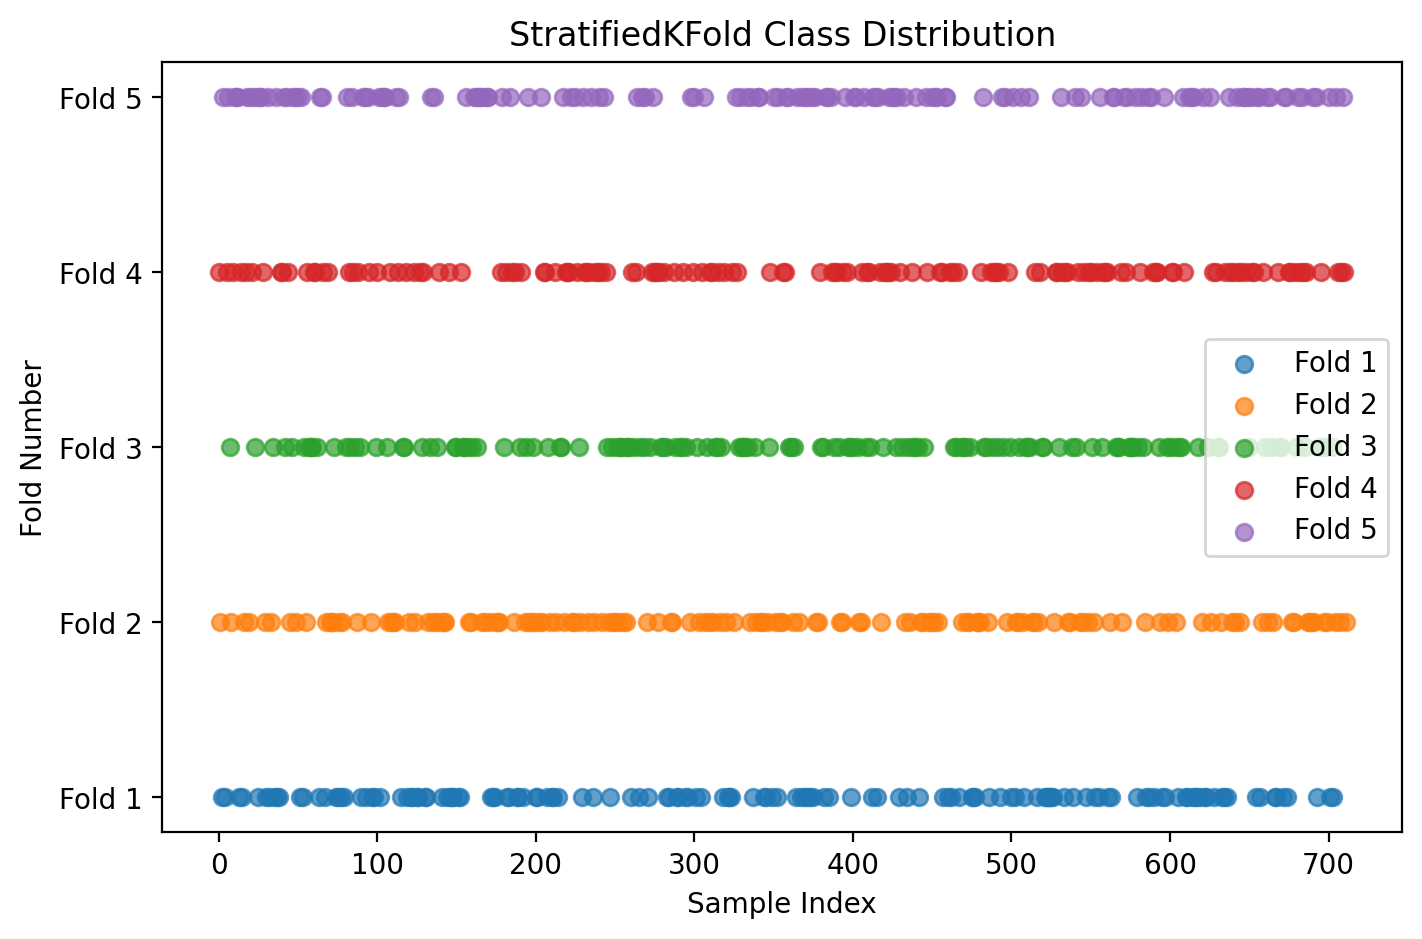

In [81]:
# Function to visualize folds
def plot_folds(folds, method_name, y_labels):
    plt.figure(figsize=(8, 5))
    for i, (train_idx, test_idx) in enumerate(folds.split(X_train, y_labels)):
        plt.scatter(test_idx, [i] * len(test_idx), label=f"Fold {i+1}", alpha=0.7)
    plt.yticks(range(5), [f"Fold {i+1}" for i in range(5)])
    plt.xlabel("Sample Index")
    plt.ylabel("Fold Number")
    plt.title(f"{method_name} Class Distribution")
    plt.legend()
    plt.show()

# Visualize StratifiedKFold before model optimization
plot_folds(skf, "StratifiedKFold", y_train)

In [82]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [83]:
def optimize_model(trial, model_type):
    params = {}
    
    if model_type == "Logistic Regression":
        params = {
            "C": trial.suggest_loguniform("C", 1e-3, 10),
            "max_iter": trial.suggest_int("max_iter", 100, 1000),
            "penalty": trial.suggest_categorical("penalty", ["l2"]),
            "solver": trial.suggest_categorical("solver", ["lbfgs", "saga", "newton-cg"]),
            "random_state": 42,
            "n_jobs": -1
        }
        model = skl.linear_model.LogisticRegression(**params)

    elif model_type == "Decision Tree":
        params = {
            "max_depth": trial.suggest_int("max_depth", 2, 30),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
            "random_state": 42
        }
        model = skl.tree.DecisionTreeClassifier(**params)

    elif model_type == "Random Forest":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "max_depth": trial.suggest_int("max_depth", 3, 30),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
            "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
            "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
            "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
            "random_state": 42,
            "n_jobs": -1
        }
        model = skl.ensemble.RandomForestClassifier(**params)

    elif model_type == "XGBoost":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "max_depth": trial.suggest_int("max_depth", 3, 15),
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
            "gamma": trial.suggest_loguniform("gamma", 1e-8, 10.0),
            "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
            "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
            "use_label_encoder": False,
            "eval_metric": "logloss",
            "n_jobs": -1,
            "random_state": 42,
        }
        model = XGBClassifier(**params)

    elif model_type == "LightGBM":
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
            "max_depth": trial.suggest_int("max_depth", 3, 30),
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
            "num_leaves": trial.suggest_int("num_leaves", 7, 512),
            "subsample": trial.suggest_uniform("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.5, 1.0),
            "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-8, 10.0),
            "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-8, 10.0),
            "random_state": 42,
            "n_jobs": -1
        }
        model = LGBMClassifier(**params)

    elif model_type == "CatBoost":
        params = {
            "iterations": trial.suggest_int("iterations", 100, 1000),
            "depth": trial.suggest_int("depth", 3, 10),
            "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.3),
            "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-3, 10.0),
            "border_count": trial.suggest_int("border_count", 32, 255),
            "random_strength": trial.suggest_uniform("random_strength", 1e-9, 10.0),
            "verbose": 0,
            "random_seed": 42,
        }
        model = CatBoostClassifier(**params)

    # score = skl.model_selection.cross_val_score(
    #     model, X_train, y_train, cv=5, scoring="accuracy", n_jobs=-1
    # )
    
    accuracies = []
    for train_idx, test_idx in skf.split(X_train, y_train):
        X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

        model.fit(X_train_fold, y_train_fold)
        accuracies.append(model.score(X_test_fold, y_test_fold))

    return np.mean(accuracies)
    
    # return score.mean()

In [ ]:
# Optimize each model

optimized_models = {}
for model_name in [
    "Logistic Regression",
    "Decision Tree",
    "Random Forest",
    "XGBoost",
    # "LightGBM",
    "CatBoost"
]:
    print(f"Optimizing {model_name}...")
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: optimize_model(trial, model_name), n_trials=20, show_progress_bar=True)
    optimized_models[model_name] = study.best_params
    print(f"Best params for {model_name}: {study.best_params}\n")

[I 2025-06-01 17:32:10,155] A new study created in memory with name: no-name-aa562e1a-96df-45c7-8cd7-bac218968975


Optimizing Logistic Regression...


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-01 17:32:19,319] Trial 0 finished with value: 0.6264158376834433 and parameters: {'C': 0.0013021855125132154, 'max_iter': 166, 'penalty': 'l2', 'solver': 'newton-cg'}. Best is trial 0 with value: 0.6264158376834433.
[I 2025-06-01 17:32:19,444] Trial 1 finished with value: 0.6587314094356348 and parameters: {'C': 0.0018115965791754313, 'max_iter': 921, 'penalty': 'l2', 'solver': 'saga'}. Best is trial 1 with value: 0.6587314094356348.
[I 2025-06-01 17:32:27,160] Trial 2 finished with value: 0.7050428444794642 and parameters: {'C': 0.003948579562632314, 'max_iter': 554, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 2 with value: 0.7050428444794642.
[I 2025-06-01 17:32:34,860] Trial 3 finished with value: 0.8131783709248499 and parameters: {'C': 0.10776819169308477, 'max_iter': 296, 'penalty': 'l2', 'solver': 'newton-cg'}. Best is trial 3 with value: 0.8131783709248499.
[I 2025-06-01 17:32:34,967] Trial 4 finished with value: 0.7991431104107161 and parameters: {'C': 0.0421

[I 2025-06-01 17:32:38,071] A new study created in memory with name: no-name-46c8e6d1-6bae-42bb-93fe-f4bb98436548


[I 2025-06-01 17:32:37,954] Trial 18 finished with value: 0.824386880724909 and parameters: {'C': 4.240698752582837, 'max_iter': 129, 'penalty': 'l2', 'solver': 'lbfgs'}. Best is trial 9 with value: 0.8258051807347583.
[I 2025-06-01 17:32:38,068] Trial 19 finished with value: 0.8244164286417808 and parameters: {'C': 0.5385376833974319, 'max_iter': 387, 'penalty': 'l2', 'solver': 'newton-cg'}. Best is trial 9 with value: 0.8258051807347583.
Best params for Logistic Regression: {'C': 1.2993282131025712, 'max_iter': 396, 'penalty': 'l2', 'solver': 'lbfgs'}

Optimizing Decision Tree...


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-01 17:32:38,129] Trial 0 finished with value: 0.8215798286220821 and parameters: {'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8215798286220821.
[I 2025-06-01 17:32:38,162] Trial 1 finished with value: 0.7977149610952429 and parameters: {'max_depth': 24, 'min_samples_split': 18, 'min_samples_leaf': 6, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.8215798286220821.
[I 2025-06-01 17:32:38,197] Trial 2 finished with value: 0.8202009258347287 and parameters: {'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 1, 'criterion': 'gini'}. Best is trial 0 with value: 0.8215798286220821.
[I 2025-06-01 17:32:38,235] Trial 3 finished with value: 0.8047473653107456 and parameters: {'max_depth': 11, 'min_samples_split': 11, 'min_samples_leaf': 4, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.8215798286220821.
[I 2025-06-01 17:32:38,263] Trial 4 finished with value: 0.7921107061952133 and

[I 2025-06-01 17:32:38,851] A new study created in memory with name: no-name-63ea4981-c75e-448e-a040-3ec410766b4b


[I 2025-06-01 17:32:38,849] Trial 19 finished with value: 0.8033093666896484 and parameters: {'max_depth': 14, 'min_samples_split': 14, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 18 with value: 0.8230276765488034.
Best params for Decision Tree: {'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 1, 'criterion': 'gini'}

Optimizing Random Forest...


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-01 17:32:41,038] Trial 0 finished with value: 0.8202009258347285 and parameters: {'n_estimators': 222, 'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 1, 'max_features': None, 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8202009258347285.
[I 2025-06-01 17:32:45,245] Trial 1 finished with value: 0.8300305328474342 and parameters: {'n_estimators': 631, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': False, 'criterion': 'gini'}. Best is trial 1 with value: 0.8300305328474342.
[I 2025-06-01 17:32:52,194] Trial 2 finished with value: 0.8342460356544864 and parameters: {'n_estimators': 806, 'max_depth': 11, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True, 'criterion': 'gini'}. Best is trial 2 with value: 0.8342460356544864.
[I 2025-06-01 17:32:57,053] Trial 3 finished with value: 0.832837584950261 and parameters: {'n_estimators': 819, 'max_depth'

[I 2025-06-01 17:34:22,397] A new study created in memory with name: no-name-31f66f2e-3ab2-4b1d-a79c-41d9d1d7ae81


[I 2025-06-01 17:34:22,397] Trial 19 finished with value: 0.821619225844578 and parameters: {'n_estimators': 503, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}. Best is trial 12 with value: 0.837082635674185.
Best params for Random Forest: {'n_estimators': 718, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'criterion': 'entropy'}

Optimizing XGBoost...


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-01 17:34:23,323] Trial 0 finished with value: 0.7865359992120555 and parameters: {'n_estimators': 404, 'max_depth': 5, 'learning_rate': 0.1886196326278422, 'subsample': 0.6463495433714187, 'colsample_bytree': 0.657141263278541, 'gamma': 0.011726879802283758, 'reg_alpha': 0.0010763769007638086, 'reg_lambda': 3.294049833376218e-08}. Best is trial 0 with value: 0.7865359992120555.
[I 2025-06-01 17:34:23,822] Trial 1 finished with value: 0.8159952723333005 and parameters: {'n_estimators': 170, 'max_depth': 15, 'learning_rate': 0.1453754314778962, 'subsample': 0.5280688253910817, 'colsample_bytree': 0.6603514698172919, 'gamma': 0.6338629974965602, 'reg_alpha': 7.528683281229321e-07, 'reg_lambda': 0.014268903864401949}. Best is trial 1 with value: 0.8159952723333005.
[I 2025-06-01 17:34:24,775] Trial 2 finished with value: 0.806155816014971 and parameters: {'n_estimators': 275, 'max_depth': 14, 'learning_rate': 0.08836700347090012, 'subsample': 0.5242878613884971, 'colsample_bytre

[I 2025-06-01 17:34:51,182] A new study created in memory with name: no-name-e9744b93-8f1c-49ce-b1d1-7f8634072772


[I 2025-06-01 17:34:51,179] Trial 19 finished with value: 0.8230079779375554 and parameters: {'n_estimators': 531, 'max_depth': 11, 'learning_rate': 0.01882184372193295, 'subsample': 0.7254466340045603, 'colsample_bytree': 0.7648817304856464, 'gamma': 3.148015417461749e-07, 'reg_alpha': 8.217314575825547, 'reg_lambda': 0.0014250040523955665}. Best is trial 11 with value: 0.8370924849798088.
Best params for XGBoost: {'n_estimators': 916, 'max_depth': 3, 'learning_rate': 0.027394236920661445, 'subsample': 0.7995159359553949, 'colsample_bytree': 0.5523604254360934, 'gamma': 2.1404514872700193e-05, 'reg_alpha': 9.417911800841616e-07, 'reg_lambda': 4.940235775104765}

Optimizing CatBoost...


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-06-01 17:34:57,689] Trial 0 finished with value: 0.8215896779277061 and parameters: {'iterations': 950, 'depth': 5, 'learning_rate': 0.02206565326421885, 'l2_leaf_reg': 0.11944312721414367, 'border_count': 86, 'random_strength': 2.7584096346434177}. Best is trial 0 with value: 0.8215896779277061.
[I 2025-06-01 17:35:08,923] Trial 1 finished with value: 0.8089530188121739 and parameters: {'iterations': 642, 'depth': 8, 'learning_rate': 0.06133732179189019, 'l2_leaf_reg': 1.4714482599210414, 'border_count': 220, 'random_strength': 8.340979959437652}. Best is trial 0 with value: 0.8215896779277061.


In [ ]:
base_model = skl.ensemble.RandomForestClassifier(**optimized_models["Random Forest"])
meta_model = skl.linear_model.LogisticRegression(**optimized_models["Logistic Regression"])

models = {
    "Logistic Regression": skl.linear_model.LogisticRegression(**optimized_models["Logistic Regression"]),
    "Decision Tree": skl.tree.DecisionTreeClassifier(**optimized_models["Decision Tree"]),
    "Random Forest": skl.ensemble.RandomForestClassifier(**optimized_models["Random Forest"]),
    "XGBoost": XGBClassifier(**optimized_models["XGBoost"]),
    # "LightGBM": LGBMClassifier(**optimized_models["LightGBM"], verbose=-1),
    "CatBoost": CatBoostClassifier(**optimized_models["CatBoost"], verbose=0),
    "Stacked Model": skl.ensemble.StackingClassifier(
        estimators=[("rf", base_model)],
        final_estimator=meta_model,
        cv=5  # Stratified cross-validation
    )
}

In [ ]:
# base_model = skl.ensemble.RandomForestClassifier(**optimized_models["Random Forest"])
# meta_model = skl.linear_model.LogisticRegression(**optimized_models["Logistic Regression"])

# # Implement stacking
# stacked_model = skl.ensemble.StackingClassifier(
#     estimators=[("rf", base_model)],
#     final_estimator=meta_model,
#     cv=5  # Stratified cross-validation
# )

In [ ]:
# # Select best-performing model (replace with actual best model)
# best_model = models["XGBoost"]  # Example

# # Fit SHAP explainer
# explainer = shap.Explainer(best_model, X_train)
# shap_values = explainer(X_test)

# # Plot feature importance
# shap.summary_plot(shap_values, X_test, feature_names=X.columns)

In [ ]:
X_Pred.head()

In [ ]:
X_Pred['Fare'].fillna(X_Pred['Fare'].median(), inplace=True)

In [ ]:
X_Pred.isna().sum()

In [ ]:
X_Pred_Passenger.head()

In [ ]:
# Train & evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = skl.metrics.accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

In [ ]:
bool_cols = X_test.select_dtypes(include=['bool']).columns
X_test[bool_cols] = X_test[bool_cols].astype(int)
X_train[bool_cols] = X_train[bool_cols].astype(int)

In [ ]:
print(X_test.dtypes)

In [ ]:
# Apply SHAP
explainer = shap.Explainer(models["Random Forest"], X_train)
shap_values = explainer(X_test) # This is the full Explanation object
print(shap_values.shape)

# Visualize feature importance
print(f"SHAP Summary for Random Forest")

# shap.summary_plot(shap_values, X_test)
print("Survival Dependence")
shap.plots.beeswarm(shap_values[..., 1])  # Select SHAP values for the survival class
print("Non-Survival Dependence")
shap.plots.beeswarm(shap_values[..., 0])  # Select SHAP values for the non-survival class

In [ ]:
# Loop through all trained models and save predictions separately
for model_name, model in models.items():
    predictions = model.predict(X_Pred)  # Generate predictions using X_Pred

    # Create a submission DataFrame with required format
    submission_df = pd.DataFrame({"PassengerId": X_Pred_Passenger, "Survived": predictions})

    # Save each model’s predictions as a separate CSV file
    filename = f"{model_name}_submission.csv"
    submission_df.to_csv(filename, index=False)
    
    print(f"Saved: {filename}")


In [ ]:
with open('random_forest.pkl', 'wb') as f:
    pickle.dump(models["Random Forest"], f)